In [1]:
import numpy as np
import pycycle as cy
import matplotlib.pyplot as plt
import scipy
%load_ext autoreload
%autoreload 2
%matplotlib notebook

Mesh creation
===========

In [2]:
b1 = (0, 40.0)
b2 = (0, 50.0)
h1 = 0.2
h2 = 1.0
star_centre = (1, 1)
normal1 = cy.mesh.line_normal((0, 0), b1, star_centre)
normal2 = cy.mesh.line_normal(b1, b2, star_centre)

# Create a mesh from origin to b1 with resolution h1
# True means on-fault
mesh = cy.mesh.tessellate_line((0, 0), b1, h1, normal1, True)
# Add a mesh from b1 to b2 with resolution h2
mesh = mesh + cy.mesh.tessellate_line(b1, b2, h2, normal2)
# Extend to infinity
mesh.append(cy.mesh.InfiniteLineElement(b2, normal2))

Parameters
==========

In [3]:
rho = 2.670   # density [g/m^3]
v_s = 3.464   # shear wave velocity [km/s]
Vp = 1e-9     # plate rate [m/s]
V0 = 1e-6     # reference slip rate [m/s]
b = 0.015     # b parameter
L = 0.008     # critical slip distance [m]
f0 = 0.6      # reference friction coefficient
sn = 50       # normal stress [MPa]
Vinit = 1e-9  # initial slip rate [m/s]
cp = cy.seas.ConstantParams(rho, v_s, Vp, V0, b, L, f0, sn, Vinit)

In [4]:
a0 = 0.010
amax = 0.025
# a parameter depends on x
def a(x):
    z = x[1]
    H = 15.0
    h = 3.0
    if z < H:
        return a0
    elif z < H + h:
        return a0 + (amax - a0) * (z - H) / h
    else:
        return amax

# pre-stress may depend on position, constant here
def tau_pre(x):
    e = np.exp((f0 + b * np.log(V0 / Vinit)) / amax)
    return -(sn * amax * np.arcsinh((Vinit / (2.0 * V0)) * e) + cp.eta * Vinit)

vp = cy.seas.VariableParams(mesh, a, tau_pre)

Compile
==========

In [5]:
# initialize solver context
ctx = cy.seas.Context(mesh, cy.green.G_fs, cy.green.dG_fs_dn, vp, cp)

/import/freenas-m-04-students/fkutschera/Master/P10/P10_NDiES/SEAS/pycycle-student/pycycle/bem.py:21: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  A[i, j] = quad(K, -1, 0)[0] + quad(K, 0, 1)[0]


Plot setup
========

<IPython.core.display.Javascript object>


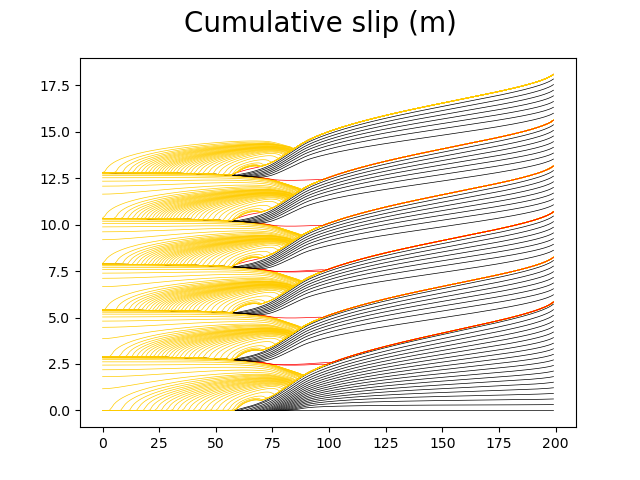

In [6]:
u_fig = plt.figure()

# fig.canvas.set_window_title('Canvas active title')
u_fig.suptitle('Cumulative slip (m)', fontsize=20)

# Create plots inside the figures
u_ax = u_fig.add_subplot(111)

<IPython.core.display.Javascript object>


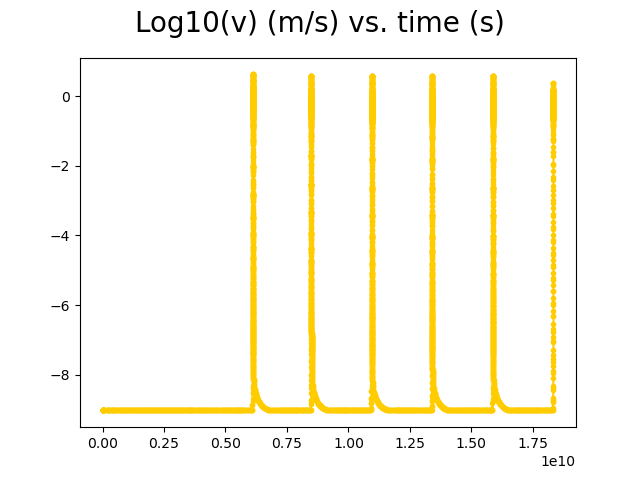

In [7]:
v_fig = plt.figure()

# fig.canvas.set_window_title('Canvas active title')
v_fig.suptitle('Log10(v) (m/s) vs. time (s)', fontsize=20)

# Create plots inside the figures
v_ax = v_fig.add_subplot(111)

In [8]:
thresholds = [
    {'color': '#000000', 'vthresh': 0,     'dt': 10*365*24*60*60, 'interval': '10 years' },
    {'color': '#ff0000', 'vthresh': 1e-06, 'dt': 24*60*60,        'interval': '1  day'   },
    {'color': '#ffcc00', 'vthresh': 1e-02, 'dt': 1,               'interval': '1  second'}
]

Initial conditions
=============

In [9]:
y0 = cy.seas.y0(ctx) # initial condition

In [10]:
t0 = 0
#tend = 8e9 # in secdonds
tend = 31536000000
tend_years = tend/60/60/24/365
print(tend_years)

1000.0


Solve
=====

In [11]:
monitor = cy.monitor.Monitor(thresholds, u_ax, u_fig, v_ax, v_fig)

def F(t, y, ctx):
    # a new step begins, take y to represent the result of last step.
    fresh = t == F.t_
    F.t_  = t
    return cy.seas.F(t,y,ctx,monitor) if fresh else cy.seas.F(t,y,ctx)
F.t_ = t0

result = scipy.integrate.solve_ivp( F, (t0, tend), y0, method='RK45', rtol=1e-7, atol=1e-7, args=(ctx,), first_step=100) #, max_step=60*60*24*365

     0 yr,   0 d,  0 h,  0 m,  0 s,   0 ms.
       v_max =  1.0000000000000036e-09 m/s |  3.153600000000011 cm/yr
     0 yr,   0 d,  0 h,  1 m, 40 s,   0 ms.
       v_max =  9.999999999144264e-10 m/s |  3.153599999730135 cm/yr
     0 yr,   0 d,  0 h, 18 m, 20 s,   0 ms.
       v_max =  9.999999905923753e-10 m/s |  3.153599970332115 cm/yr
     0 yr,   0 d,  1 h, 33 m, 55 s,  60 ms.
       v_max =  9.999998242084136e-10 m/s |  3.153599445623653 cm/yr
     0 yr,   0 d,  3 h, 10 m, 42 s, 120 ms.
       v_max =  9.99999466387497e-10 m/s |  3.153598317199611 cm/yr
     0 yr,   0 d,  5 h, 33 m, 32 s, 180 ms.
       v_max =  9.99998817201735e-10 m/s |  3.1535962699273914 cm/yr
     0 yr,   0 d,  8 h, 57 m, 57 s, 776 ms.
       v_max =  9.999977800322972e-10 m/s |  3.1535929991098524 cm/yr
     0 yr,   0 d, 13 h, 52 m, 22 s, 719 ms.
       v_max =  9.999961873297204e-10 m/s |  3.1535879763630064 cm/yr
     0 yr,   0 d, 20 h, 55 m, 53 s, 396 ms.
       v_max =  9.999938005368385e-10 m/s |  3.153

    31 yr,  56 d, 18 h, 57 m,  5 s, 218 ms.
       v_max =  9.547734891898974e-10 m/s |  3.0109736755092604 cm/yr
    31 yr, 351 d,  8 h, 24 m, 19 s,  31 ms.
       v_max =  9.545388328768618e-10 m/s |  3.0102336633604714 cm/yr
    31 yr, 306 d, 13 h, 35 m,  5 s, 346 ms.
       v_max =  9.54544479926628e-10 m/s |  3.010251471896614 cm/yr
    32 yr, 191 d,  8 h, 13 m,  5 s, 474 ms.
       v_max =  9.542759712042877e-10 m/s |  3.009404702789842 cm/yr
    33 yr, 162 d, 20 h, 46 m, 15 s, 614 ms.
       v_max =  9.539467316275632e-10 m/s |  3.008366412860683 cm/yr
    34 yr, 115 d, 11 h, 29 m, 41 s, 480 ms.
       v_max =  9.537525013087378e-10 m/s |  3.0077538881272354 cm/yr
    35 yr,  65 d, 12 h, 55 m, 40 s, 954 ms.
       v_max =  9.535710385787132e-10 m/s |  3.0071816272618297 cm/yr
    34 yr, 346 d, 10 h, 58 m, 48 s, 290 ms.
       v_max =  9.535542980042642e-10 m/s |  3.0071288341862474 cm/yr
    35 yr, 212 d, 10 h, 27 m, 55 s, 100 ms.
       v_max =  9.533528328199801e-10 m/s |  3.0

    72 yr, 210 d, 14 h,  8 m,  3 s, 663 ms.
       v_max =  9.502865209760444e-10 m/s |  2.9968235725500536 cm/yr
    73 yr, 218 d,  2 h, 18 m, 53 s, 911 ms.
       v_max =  9.503508673690223e-10 m/s |  2.9970264953349486 cm/yr
    73 yr, 149 d,  1 h, 43 m, 27 s, 734 ms.
       v_max =  9.50299806063932e-10 m/s |  2.9968654684032163 cm/yr
    74 yr,  87 d, 13 h, 18 m, 51 s, 805 ms.
       v_max =  9.50264196152455e-10 m/s |  2.996753168986382 cm/yr
    75 yr, 104 d, 21 h,  6 m, 46 s, 686 ms.
       v_max =  9.501641513606596e-10 m/s |  2.996437667730976 cm/yr
    74 yr, 354 d,  3 h, 23 m, 57 s, 362 ms.
       v_max =  9.502765574427338e-10 m/s |  2.9967921515514053 cm/yr
    75 yr, 255 d, 17 h, 29 m,  2 s, 918 ms.
       v_max =  9.503071183357298e-10 m/s |  2.9968885283835576 cm/yr
    76 yr, 266 d,  5 h, 46 m, 50 s,  14 ms.
       v_max =  9.503402827708584e-10 m/s |  2.9969931157461795 cm/yr
    76 yr, 209 d,  4 h, 28 m, 57 s, 435 ms.
       v_max =  9.503152418609642e-10 m/s |  2.9

   113 yr, 286 d,  4 h,  7 m,  5 s, 262 ms.
       v_max =  9.51225238926607e-10 m/s |  2.9997839134789475 cm/yr
   113 yr, 228 d, 15 h, 29 m, 31 s, 148 ms.
       v_max =  9.512414636176235e-10 m/s |  2.9998350796645377 cm/yr
   114 yr, 164 d, 12 h, 34 m, 45 s, 940 ms.
       v_max =  9.51317373814201e-10 m/s |  3.000074470060464 cm/yr
   115 yr, 125 d, 23 h, 55 m, 50 s, 744 ms.
       v_max =  9.51349121704649e-10 m/s |  3.0001745902077817 cm/yr
   115 yr,  79 d, 17 h, 25 m,  3 s, 658 ms.
       v_max =  9.513306088407654e-10 m/s |  3.0001162080402377 cm/yr
   115 yr, 359 d, 22 h, 15 m, 21 s, 376 ms.
       v_max =  9.513348262560094e-10 m/s |  3.0001295080809514 cm/yr
   116 yr, 302 d, 15 h, 31 m, 19 s, 316 ms.
       v_max =  9.513924226330536e-10 m/s |  3.0003111440155976 cm/yr
   117 yr, 247 d,  1 h, 30 m,  3 s, 789 ms.
       v_max =  9.514867477522949e-10 m/s |  3.000608607711637 cm/yr
   118 yr, 167 d, 16 h, 31 m, 35 s, 638 ms.
       v_max =  9.51462491057403e-10 m/s |  3.000

   161 yr, 253 d, 13 h,  2 m,  3 s, 689 ms.
       v_max =  9.541056274213109e-10 m/s |  3.008867506635846 cm/yr
   161 yr, 220 d, 14 h,  3 m, 30 s,  91 ms.
       v_max =  9.540992296076888e-10 m/s |  3.0088473304908074 cm/yr
   162 yr, 121 d, 18 h, 57 m,  3 s, 479 ms.
       v_max =  9.54150755400627e-10 m/s |  3.009009822231417 cm/yr
   163 yr,  23 d,  1 h, 37 m, 31 s, 273 ms.
       v_max =  9.54203079806531e-10 m/s |  3.009174832477876 cm/yr
   163 yr, 289 d,  3 h, 37 m,  8 s, 775 ms.
       v_max =  9.542555057686736e-10 m/s |  3.009340162992089 cm/yr
   164 yr, 178 d, 18 h, 10 m, 53 s, 436 ms.
       v_max =  9.543048720755396e-10 m/s |  3.0094958445774216 cm/yr
   165 yr,  60 d, 18 h,  5 m, 38 s, 377 ms.
       v_max =  9.54352058131621e-10 m/s |  3.0096446505238803 cm/yr
   165 yr, 338 d,  3 h, 11 m, 31 s,  30 ms.
       v_max =  9.544049789902253e-10 m/s |  3.0098115417435745 cm/yr
   166 yr, 273 d,  3 h, 54 m,  8 s, 938 ms.
       v_max =  9.544631760285197e-10 m/s |  3.0099

   193 yr, 268 d,  0 h, 47 m, 34 s, 135 ms.
       v_max =  6.245873525264566e-08 m/s |  196.96986749274336 cm/yr
   193 yr, 269 d, 14 h, 38 m, 36 s, 595 ms.
       v_max =  1.3128536600946928e-07 m/s |  414.02153024746235 cm/yr
   193 yr, 269 d,  2 h, 42 m, 45 s, 668 ms.
       v_max =  9.608309210808517e-08 m/s |  303.00763927205736 cm/yr
   193 yr, 270 d,  4 h, 37 m, 57 s, 202 ms.
       v_max =  2.3772283449904073e-07 m/s |  749.6827308761749 cm/yr
   193 yr, 269 d, 17 h, 53 m, 34 s, 862 ms.
       v_max =  1.4607388434703646e-07 m/s |  460.65860167681416 cm/yr
   193 yr, 270 d,  9 h,  4 m, 24 s,  56 ms.
       v_max =  3.2221194996370385e-07 m/s |  1016.1276054055364 cm/yr
   193 yr, 270 d,  4 h, 18 m, 45 s, 513 ms.
       v_max =  2.3334023403567623e-07 m/s |  735.8617620549086 cm/yr
   193 yr, 270 d, 14 h, 43 m, 56 s, 163 ms.
       v_max =  5.934015927233645e-07 m/s |  1871.3512628124024 cm/yr
   193 yr, 270 d, 10 h, 22 m, 23 s, 185 ms.
       v_max =  3.5982365411540863e-07 m/

   193 yr, 270 d, 21 h, 21 m,  2 s,  61 ms.
       v_max =  0.16349077969740977 m/s |  515584522.8537515 cm/yr
appending to plot stack
   193 yr, 270 d, 21 h, 21 m,  2 s,  45 ms.
       v_max =  0.1618968372320192 m/s |  510557865.89489573 cm/yr
   193 yr, 270 d, 21 h, 21 m,  2 s,  97 ms.
       v_max =  0.16719384887885191 m/s |  527262521.8243474 cm/yr
   193 yr, 270 d, 21 h, 21 m,  2 s, 151 ms.
       v_max =  0.1737945765285514 m/s |  548078576.5404397 cm/yr
   193 yr, 270 d, 21 h, 21 m,  2 s, 216 ms.
       v_max =  0.18337306759031394 m/s |  578285305.952814 cm/yr
   193 yr, 270 d, 21 h, 21 m,  2 s, 290 ms.
       v_max =  0.205063428527027 m/s |  646688028.2028323 cm/yr
   193 yr, 270 d, 21 h, 21 m,  2 s, 365 ms.
       v_max =  0.23320987417488492 m/s |  735450659.1979171 cm/yr
   193 yr, 270 d, 21 h, 21 m,  2 s, 441 ms.
       v_max =  0.21636720038532925 m/s |  682335603.1351743 cm/yr
   193 yr, 270 d, 21 h, 21 m,  2 s, 408 ms.
       v_max =  0.23213797291459917 m/s |  73207

   193 yr, 270 d, 21 h, 21 m,  4 s,  35 ms.
       v_max =  0.5654075563130428 m/s |  1783069269.5888119 cm/yr
   193 yr, 270 d, 21 h, 21 m,  4 s,  32 ms.
       v_max =  0.5745701416293099 m/s |  1811964398.6421916 cm/yr
   193 yr, 270 d, 21 h, 21 m,  4 s,  54 ms.
       v_max =  0.4980938706620063 m/s |  1570788830.519703 cm/yr
   193 yr, 270 d, 21 h, 21 m,  4 s,  52 ms.
       v_max =  0.5072326873599589 m/s |  1599609002.8583663 cm/yr
   193 yr, 270 d, 21 h, 21 m,  4 s,  72 ms.
       v_max =  0.4580701807111629 m/s |  1444570121.8907232 cm/yr
   193 yr, 270 d, 21 h, 21 m,  4 s,  69 ms.
       v_max =  0.4574806239362151 m/s |  1442710895.645248 cm/yr
   193 yr, 270 d, 21 h, 21 m,  4 s,  86 ms.
       v_max =  0.46129308901508587 m/s |  1454733885.5179749 cm/yr
   193 yr, 270 d, 21 h, 21 m,  4 s, 107 ms.
       v_max =  0.46607414158853044 m/s |  1469811412.9135897 cm/yr
   193 yr, 270 d, 21 h, 21 m,  4 s, 130 ms.
       v_max =  0.47297997663396746 m/s |  1491589654.3128796 cm/yr


   193 yr, 270 d, 21 h, 21 m,  5 s, 588 ms.
       v_max =  0.5325833664912475 m/s |  1679554904.5667982 cm/yr
   193 yr, 270 d, 21 h, 21 m,  5 s, 625 ms.
       v_max =  0.5422693174200455 m/s |  1710100519.4158554 cm/yr
   193 yr, 270 d, 21 h, 21 m,  5 s, 670 ms.
       v_max =  0.5512319942078857 m/s |  1738365216.9339883 cm/yr
   193 yr, 270 d, 21 h, 21 m,  5 s, 725 ms.
       v_max =  0.5666853869953947 m/s |  1787099036.4286768 cm/yr
   193 yr, 270 d, 21 h, 21 m,  5 s, 783 ms.
       v_max =  0.6150212189613269 m/s |  1939530916.1164405 cm/yr
   193 yr, 270 d, 21 h, 21 m,  5 s, 763 ms.
       v_max =  0.595884414839267 m/s |  1879181090.6371124 cm/yr
   193 yr, 270 d, 21 h, 21 m,  5 s, 800 ms.
       v_max =  0.6164449280860098 m/s |  1944020725.2120404 cm/yr
   193 yr, 270 d, 21 h, 21 m,  5 s, 789 ms.
       v_max =  0.6189809453070817 m/s |  1952018309.1204128 cm/yr
   193 yr, 270 d, 21 h, 21 m,  5 s, 816 ms.
       v_max =  0.58577206887536 m/s |  1847290796.4053354 cm/yr
   1

   193 yr, 270 d, 21 h, 21 m,  7 s, 286 ms.
       v_max =  0.5805934196307694 m/s |  1830959408.1475945 cm/yr
   193 yr, 270 d, 21 h, 21 m,  7 s, 276 ms.
       v_max =  0.5720016268719567 m/s |  1803864330.5034025 cm/yr
   193 yr, 270 d, 21 h, 21 m,  7 s, 328 ms.
       v_max =  0.5966854107530024 m/s |  1881707111.3506684 cm/yr
   193 yr, 270 d, 21 h, 21 m,  7 s, 300 ms.
       v_max =  0.5945530089497568 m/s |  1874982369.023953 cm/yr
   193 yr, 270 d, 21 h, 21 m,  7 s, 324 ms.
       v_max =  0.6014956459138194 m/s |  1896876668.953821 cm/yr
   193 yr, 270 d, 21 h, 21 m,  7 s, 358 ms.
       v_max =  0.5089937141494469 m/s |  1605162576.941696 cm/yr
   193 yr, 270 d, 21 h, 21 m,  7 s, 344 ms.
       v_max =  0.5620312520974405 m/s |  1772421756.6144884 cm/yr
   193 yr, 270 d, 21 h, 21 m,  7 s, 363 ms.
       v_max =  0.4903108792625325 m/s |  1546244388.8423226 cm/yr
   193 yr, 270 d, 21 h, 21 m,  7 s, 360 ms.
       v_max =  0.5003716676471412 m/s |  1577972091.0920246 cm/yr
   1

   193 yr, 270 d, 21 h, 21 m,  8 s, 921 ms.
       v_max =  0.5501320589494146 m/s |  1734896461.102874 cm/yr
   193 yr, 270 d, 21 h, 21 m,  8 s, 940 ms.
       v_max =  0.4846294963961991 m/s |  1528327579.8350537 cm/yr
   193 yr, 270 d, 21 h, 21 m,  8 s, 959 ms.
       v_max =  0.4214948356231778 m/s |  1329226113.6212537 cm/yr
   193 yr, 270 d, 21 h, 21 m,  8 s, 977 ms.
       v_max =  0.4389516248909947 m/s |  1384277844.2562408 cm/yr
   193 yr, 270 d, 21 h, 21 m,  8 s, 999 ms.
       v_max =  0.46110200080079766 m/s |  1454131269.7253954 cm/yr
   193 yr, 270 d, 21 h, 21 m,  9 s,  23 ms.
       v_max =  0.4779364218207301 m/s |  1507220299.8538544 cm/yr
appending to plot stack
   193 yr, 270 d, 21 h, 21 m,  9 s,  52 ms.
       v_max =  0.49046210586725003 m/s |  1546721297.0629597 cm/yr
   193 yr, 270 d, 21 h, 21 m,  9 s,  85 ms.
       v_max =  0.4999899497589545 m/s |  1576768305.559839 cm/yr
   193 yr, 270 d, 21 h, 21 m,  9 s, 125 ms.
       v_max =  0.5076998517389415 m/s |  16

   193 yr, 270 d, 21 h, 21 m, 10 s, 755 ms.
       v_max =  0.48819258679993643 m/s |  1539564141.7322795 cm/yr
   193 yr, 270 d, 21 h, 21 m, 10 s, 802 ms.
       v_max =  0.4948020514009823 m/s |  1560407749.298138 cm/yr
   193 yr, 270 d, 21 h, 21 m, 10 s, 859 ms.
       v_max =  0.5028029967875627 m/s |  1585639530.6692576 cm/yr
   193 yr, 270 d, 21 h, 21 m, 10 s, 924 ms.
       v_max =  0.5348979377698111 m/s |  1686854136.5508764 cm/yr
   193 yr, 270 d, 21 h, 21 m, 10 s, 913 ms.
       v_max =  0.5262673479716534 m/s |  1659636708.5634062 cm/yr
   193 yr, 270 d, 21 h, 21 m, 10 s, 967 ms.
       v_max =  0.5457938045416941 m/s |  1721215342.0026865 cm/yr
   193 yr, 270 d, 21 h, 21 m, 10 s, 939 ms.
       v_max =  0.5471989257826753 m/s |  1725646532.3482447 cm/yr
   193 yr, 270 d, 21 h, 21 m, 10 s, 965 ms.
       v_max =  0.5490123487253858 m/s |  1731365342.940377 cm/yr
   193 yr, 270 d, 21 h, 21 m, 11 s,   0 ms.
       v_max =  0.4603282306714268 m/s |  1451691108.2454116 cm/yr
  

   193 yr, 270 d, 21 h, 21 m, 12 s, 656 ms.
       v_max =  0.5345601978958511 m/s |  1685789040.0843558 cm/yr
   193 yr, 270 d, 21 h, 21 m, 12 s, 681 ms.
       v_max =  0.4652608618053662 m/s |  1467246653.7894027 cm/yr
   193 yr, 270 d, 21 h, 21 m, 12 s, 678 ms.
       v_max =  0.47576896776888705 m/s |  1500385016.7559621 cm/yr
   193 yr, 270 d, 21 h, 21 m, 12 s, 699 ms.
       v_max =  0.4069717339324202 m/s |  1283426060.1292803 cm/yr
   193 yr, 270 d, 21 h, 21 m, 12 s, 696 ms.
       v_max =  0.4149809425948586 m/s |  1308683900.567146 cm/yr
   193 yr, 270 d, 21 h, 21 m, 12 s, 715 ms.
       v_max =  0.41462475086244643 m/s |  1307560614.319811 cm/yr
   193 yr, 270 d, 21 h, 21 m, 12 s, 736 ms.
       v_max =  0.4373751076905833 m/s |  1379306139.6130235 cm/yr
   193 yr, 270 d, 21 h, 21 m, 12 s, 761 ms.
       v_max =  0.45454794729556947 m/s |  1433462406.5913079 cm/yr
   193 yr, 270 d, 21 h, 21 m, 12 s, 790 ms.
       v_max =  0.4671293526013194 m/s |  1473139126.3635206 cm/yr


   193 yr, 270 d, 21 h, 21 m, 14 s, 489 ms.
       v_max =  0.47012918306434737 m/s |  1482599391.7117257 cm/yr
   193 yr, 270 d, 21 h, 21 m, 14 s, 524 ms.
       v_max =  0.4788984310635625 m/s |  1510254092.2020507 cm/yr
   193 yr, 270 d, 21 h, 21 m, 14 s, 565 ms.
       v_max =  0.4860841946506179 m/s |  1532915116.2501886 cm/yr
   193 yr, 270 d, 21 h, 21 m, 14 s, 616 ms.
       v_max =  0.49278341621043764 m/s |  1554041781.361236 cm/yr
   193 yr, 270 d, 21 h, 21 m, 14 s, 678 ms.
       v_max =  0.5054433555979239 m/s |  1593966166.2136128 cm/yr
   193 yr, 270 d, 21 h, 21 m, 14 s, 739 ms.
       v_max =  0.5472063230131599 m/s |  1725669860.254301 cm/yr
   193 yr, 270 d, 21 h, 21 m, 14 s, 719 ms.
       v_max =  0.5315115634870018 m/s |  1676174866.6126087 cm/yr
   193 yr, 270 d, 21 h, 21 m, 14 s, 760 ms.
       v_max =  0.546452253798831 m/s |  1723291827.5799935 cm/yr
   193 yr, 270 d, 21 h, 21 m, 14 s, 749 ms.
       v_max =  0.551031417372532 m/s |  1737732677.826017 cm/yr
   1

   193 yr, 270 d, 21 h, 21 m, 16 s, 351 ms.
       v_max =  0.5451952655022816 m/s |  1719327789.287995 cm/yr
   193 yr, 270 d, 21 h, 21 m, 16 s, 406 ms.
       v_max =  0.575730982425328 m/s |  1815625226.1765146 cm/yr
   193 yr, 270 d, 21 h, 21 m, 16 s, 377 ms.
       v_max =  0.5685099143458273 m/s |  1792852865.881001 cm/yr
   193 yr, 270 d, 21 h, 21 m, 16 s, 402 ms.
       v_max =  0.5791020011810782 m/s |  1826256070.9246483 cm/yr
   193 yr, 270 d, 21 h, 21 m, 16 s, 436 ms.
       v_max =  0.49675472952956307 m/s |  1566565715.04443 cm/yr
   193 yr, 270 d, 21 h, 21 m, 16 s, 422 ms.
       v_max =  0.5458748532444104 m/s |  1721470937.1915727 cm/yr
   193 yr, 270 d, 21 h, 21 m, 16 s, 441 ms.
       v_max =  0.4794816720628813 m/s |  1512093401.0175023 cm/yr
   193 yr, 270 d, 21 h, 21 m, 16 s, 459 ms.
       v_max =  0.4205415842126158 m/s |  1326219939.9729052 cm/yr
   193 yr, 270 d, 21 h, 21 m, 16 s, 477 ms.
       v_max =  0.44762377915722784 m/s |  1411626349.950234 cm/yr
   19

   193 yr, 270 d, 21 h, 21 m, 18 s,  11 ms.
       v_max =  0.4502065192192126 m/s |  1419771279.009709 cm/yr
   193 yr, 270 d, 21 h, 21 m, 18 s,  29 ms.
       v_max =  0.47786213638858094 m/s |  1506986033.315029 cm/yr
   193 yr, 270 d, 21 h, 21 m, 18 s,  49 ms.
       v_max =  0.5003095084717619 m/s |  1577776065.9165485 cm/yr
   193 yr, 270 d, 21 h, 21 m, 18 s,  73 ms.
       v_max =  0.5178720865366288 m/s |  1633161412.1019123 cm/yr
   193 yr, 270 d, 21 h, 21 m, 18 s, 101 ms.
       v_max =  0.5314135119667405 m/s |  1675865651.3383126 cm/yr
   193 yr, 270 d, 21 h, 21 m, 18 s, 134 ms.
       v_max =  0.542178178306005 m/s |  1709813103.1058176 cm/yr
   193 yr, 270 d, 21 h, 21 m, 18 s, 173 ms.
       v_max =  0.5513552914926082 m/s |  1738754047.251089 cm/yr
   193 yr, 270 d, 21 h, 21 m, 18 s, 220 ms.
       v_max =  0.5608926878033355 m/s |  1768831180.2565987 cm/yr
   193 yr, 270 d, 21 h, 21 m, 18 s, 279 ms.
       v_max =  0.589916345969133 m/s |  1860360188.6482577 cm/yr
   19

   193 yr, 270 d, 21 h, 21 m, 19 s, 618 ms.
       v_max =  0.608730059946309 m/s |  1919691117.0466802 cm/yr
   193 yr, 270 d, 21 h, 21 m, 19 s, 666 ms.
       v_max =  0.6251066380750832 m/s |  1971336293.8335822 cm/yr
   193 yr, 270 d, 21 h, 21 m, 19 s, 720 ms.
       v_max =  0.6818438583284253 m/s |  2150262791.624522 cm/yr
   193 yr, 270 d, 21 h, 21 m, 19 s, 706 ms.
       v_max =  0.6630863414080849 m/s |  2091109086.2645366 cm/yr
   193 yr, 270 d, 21 h, 21 m, 19 s, 747 ms.
       v_max =  0.6944870976741089 m/s |  2190134511.22507 cm/yr
   193 yr, 270 d, 21 h, 21 m, 19 s, 728 ms.
       v_max =  0.6920350611955368 m/s |  2182401768.9862447 cm/yr
   193 yr, 270 d, 21 h, 21 m, 19 s, 749 ms.
       v_max =  0.691618838731165 m/s |  2181089169.8226023 cm/yr
   193 yr, 270 d, 21 h, 21 m, 19 s, 775 ms.
       v_max =  0.5925193130140705 m/s |  1868568905.5211728 cm/yr
   193 yr, 270 d, 21 h, 21 m, 19 s, 764 ms.
       v_max =  0.6438737293779055 m/s |  2030520192.9661632 cm/yr
   193

   193 yr, 270 d, 21 h, 21 m, 20 s, 992 ms.
       v_max =  0.817187014218687 m/s |  2577080968.0400515 cm/yr
   193 yr, 270 d, 21 h, 21 m, 21 s,  17 ms.
       v_max =  0.7306740927516585 m/s |  2304253818.9016304 cm/yr
appending to plot stack
   193 yr, 270 d, 21 h, 21 m, 21 s,   9 ms.
       v_max =  0.7738600267723582 m/s |  2440444980.429309 cm/yr
   193 yr, 270 d, 21 h, 21 m, 21 s,  25 ms.
       v_max =  0.6806220399430538 m/s |  2146409665.1644144 cm/yr
   193 yr, 270 d, 21 h, 21 m, 21 s,  19 ms.
       v_max =  0.7154985890755793 m/s |  2256396350.508747 cm/yr
   193 yr, 270 d, 21 h, 21 m, 21 s,  30 ms.
       v_max =  0.6536465078027641 m/s |  2061339627.0067968 cm/yr
   193 yr, 270 d, 21 h, 21 m, 21 s,  42 ms.
       v_max =  0.593442300204888 m/s |  1871479637.9261346 cm/yr
   193 yr, 270 d, 21 h, 21 m, 21 s,  55 ms.
       v_max =  0.6231382492721443 m/s |  1965128782.9046345 cm/yr
   193 yr, 270 d, 21 h, 21 m, 21 s,  72 ms.
       v_max =  0.6518102465198496 m/s |  205554

   193 yr, 270 d, 21 h, 21 m, 22 s,  81 ms.
       v_max =  0.7982558933275643 m/s |  2517379785.197807 cm/yr
   193 yr, 270 d, 21 h, 21 m, 22 s,  91 ms.
       v_max =  0.7343281747713355 m/s |  2315777331.958884 cm/yr
   193 yr, 270 d, 21 h, 21 m, 22 s, 103 ms.
       v_max =  0.7540927724447312 m/s |  2378106967.181704 cm/yr
   193 yr, 270 d, 21 h, 21 m, 22 s, 117 ms.
       v_max =  0.7882875869353375 m/s |  2485943734.159281 cm/yr
   193 yr, 270 d, 21 h, 21 m, 22 s, 133 ms.
       v_max =  0.8191922793192463 m/s |  2583404772.0611753 cm/yr
   193 yr, 270 d, 21 h, 21 m, 22 s, 153 ms.
       v_max =  0.8464569181778754 m/s |  2669386537.1657476 cm/yr
   193 yr, 270 d, 21 h, 21 m, 22 s, 176 ms.
       v_max =  0.8709580867541222 m/s |  2746653422.3878 cm/yr
   193 yr, 270 d, 21 h, 21 m, 22 s, 204 ms.
       v_max =  0.8981998531125767 m/s |  2832563056.7758217 cm/yr
   193 yr, 270 d, 21 h, 21 m, 22 s, 238 ms.
       v_max =  0.957873153461298 m/s |  3020748776.7555494 cm/yr
   193 yr

   193 yr, 270 d, 21 h, 21 m, 22 s, 958 ms.
       v_max =  1.1024514150061435 m/s |  3476690782.363374 cm/yr
   193 yr, 270 d, 21 h, 21 m, 22 s, 975 ms.
       v_max =  1.1461035831227022 m/s |  3614352259.7357535 cm/yr
   193 yr, 270 d, 21 h, 21 m, 22 s, 994 ms.
       v_max =  1.2029648196301967 m/s |  3793669855.1857886 cm/yr
   193 yr, 270 d, 21 h, 21 m, 23 s,  18 ms.
       v_max =  1.298489707571278 m/s |  4094917141.7967825 cm/yr
appending to plot stack
   193 yr, 270 d, 21 h, 21 m, 23 s,  46 ms.
       v_max =  1.4502517560418642 m/s |  4573513937.853622 cm/yr
   193 yr, 270 d, 21 h, 21 m, 23 s,  34 ms.
       v_max =  1.3843988617819727 m/s |  4365840250.515629 cm/yr
   193 yr, 270 d, 21 h, 21 m, 23 s,  49 ms.
       v_max =  1.4607539845330961 m/s |  4606633765.623572 cm/yr
   193 yr, 270 d, 21 h, 21 m, 23 s,  46 ms.
       v_max =  1.4507034589258856 m/s |  4574938428.068673 cm/yr
   193 yr, 270 d, 21 h, 21 m, 23 s,  59 ms.
       v_max =  1.4398751797515401 m/s |  45407903

   193 yr, 270 d, 21 h, 21 m, 23 s, 469 ms.
       v_max =  4.207480304165369 m/s |  13268709887.215908 cm/yr
   193 yr, 270 d, 21 h, 21 m, 23 s, 467 ms.
       v_max =  4.216537325346309 m/s |  13297272109.21212 cm/yr
   193 yr, 270 d, 21 h, 21 m, 23 s, 470 ms.
       v_max =  4.185230156623447 m/s |  13198541821.927704 cm/yr
   193 yr, 270 d, 21 h, 21 m, 23 s, 469 ms.
       v_max =  4.203539033262494 m/s |  13256280695.296602 cm/yr
   193 yr, 270 d, 21 h, 21 m, 23 s, 471 ms.
       v_max =  4.164611449523136 m/s |  13133518667.216162 cm/yr
   193 yr, 270 d, 21 h, 21 m, 23 s, 473 ms.
       v_max =  4.111120942917191 m/s |  12964831005.583654 cm/yr
   193 yr, 270 d, 21 h, 21 m, 23 s, 475 ms.
       v_max =  4.04809893680053 m/s |  12766084807.09415 cm/yr
   193 yr, 270 d, 21 h, 21 m, 23 s, 477 ms.
       v_max =  3.9743120266471017 m/s |  12533390407.234299 cm/yr
   193 yr, 270 d, 21 h, 21 m, 23 s, 480 ms.
       v_max =  3.8878249097597464 m/s |  12260644635.418335 cm/yr
   193 yr, 

   193 yr, 270 d, 21 h, 21 m, 25 s, 129 ms.
       v_max =  0.4335303543709941 m/s |  1367181325.5443668 cm/yr
   193 yr, 270 d, 21 h, 21 m, 25 s, 193 ms.
       v_max =  0.4205111530923474 m/s |  1326123972.3920267 cm/yr
   193 yr, 270 d, 21 h, 21 m, 25 s, 260 ms.
       v_max =  0.40778129797689466 m/s |  1285979101.299935 cm/yr
   193 yr, 270 d, 21 h, 21 m, 25 s, 328 ms.
       v_max =  0.3953261999817676 m/s |  1246700704.2625024 cm/yr
   193 yr, 270 d, 21 h, 21 m, 25 s, 399 ms.
       v_max =  0.3831320284765324 m/s |  1208245165.0035925 cm/yr
   193 yr, 270 d, 21 h, 21 m, 25 s, 472 ms.
       v_max =  0.3711854120450536 m/s |  1170570315.425281 cm/yr
   193 yr, 270 d, 21 h, 21 m, 25 s, 548 ms.
       v_max =  0.35947308987974697 m/s |  1133634336.24477 cm/yr
   193 yr, 270 d, 21 h, 21 m, 25 s, 626 ms.
       v_max =  0.34798263484123954 m/s |  1097398037.235333 cm/yr
   193 yr, 270 d, 21 h, 21 m, 25 s, 708 ms.
       v_max =  0.3367016673657526 m/s |  1061822378.2046372 cm/yr
   

   193 yr, 270 d, 21 h, 21 m, 52 s, 754 ms.
       v_max =  0.0022335905186416966 m/s |  7043851.059588455 cm/yr
   193 yr, 270 d, 21 h, 21 m, 55 s, 489 ms.
       v_max =  0.0017703165558709015 m/s |  5582870.290594474 cm/yr
   193 yr, 270 d, 21 h, 21 m, 59 s, 119 ms.
       v_max =  0.0013776250417667877 m/s |  4344478.331715741 cm/yr
   193 yr, 270 d, 21 h, 22 m,  3 s, 772 ms.
       v_max =  0.0013878136850713116 m/s |  4376609.237240888 cm/yr
   193 yr, 270 d, 21 h, 22 m,  9 s, 497 ms.
       v_max =  0.0014699166706785987 m/s |  4635529.2126520295 cm/yr
   193 yr, 270 d, 21 h, 22 m, 16 s, 319 ms.
       v_max =  0.001518846328534938 m/s |  4789833.781667781 cm/yr
   193 yr, 270 d, 21 h, 22 m, 24 s, 338 ms.
       v_max =  0.0015441968364942982 m/s |  4869779.143568419 cm/yr
   193 yr, 270 d, 21 h, 22 m, 33 s, 827 ms.
       v_max =  0.001555123249580822 m/s |  4904236.67987808 cm/yr
   193 yr, 270 d, 21 h, 22 m, 45 s, 423 ms.
       v_max =  0.0015540964563039018 m/s |  4900998.5

   193 yr, 271 d,  0 h, 57 m, 10 s, 623 ms.
       v_max =  1.2902768942030684e-05 m/s |  40690.17213558797 cm/yr
   193 yr, 271 d,  1 h, 16 m, 33 s, 152 ms.
       v_max =  1.1636942396503663e-05 m/s |  36698.26154161395 cm/yr
   193 yr, 271 d,  1 h, 14 m,  3 s, 399 ms.
       v_max =  1.1960881275237241e-05 m/s |  37719.835189588164 cm/yr
   193 yr, 271 d,  1 h, 30 m, 56 s, 175 ms.
       v_max =  9.188845279915336e-06 m/s |  28977.942474741005 cm/yr
   193 yr, 271 d,  1 h, 27 m, 25 s, 166 ms.
       v_max =  9.818223200586768e-06 m/s |  30962.748685370432 cm/yr
   193 yr, 271 d,  1 h, 40 m, 46 s, 933 ms.
       v_max =  7.615371774004803e-06 m/s |  24015.836426501548 cm/yr
   193 yr, 271 d,  1 h, 55 m, 24 s, 738 ms.
       v_max =  6.04203527931423e-06 m/s |  19054.16245684536 cm/yr
   193 yr, 271 d,  2 h, 16 m, 25 s, 400 ms.
       v_max =  6.1248294549696966e-06 m/s |  19315.262169192436 cm/yr
   193 yr, 271 d,  2 h, 38 m, 25 s, 506 ms.
       v_max =  6.714028631928957e-06 m/s | 

   193 yr, 275 d,  4 h, 16 m, 12 s, 603 ms.
       v_max =  4.3736575358280536e-07 m/s |  1379.276640498735 cm/yr
   193 yr, 275 d,  9 h, 35 m, 59 s, 934 ms.
       v_max =  5.08817048083768e-07 m/s |  1604.6054428369707 cm/yr
   193 yr, 275 d, 15 h, 16 m, 30 s,  52 ms.
       v_max =  5.492442312225751e-07 m/s |  1732.0966075835127 cm/yr
   193 yr, 275 d, 20 h, 52 m, 54 s,  32 ms.
       v_max =  5.212408769431212e-07 m/s |  1643.7852295278271 cm/yr
   193 yr, 276 d,  2 h, 12 m, 55 s, 815 ms.
       v_max =  4.3232678161895676e-07 m/s |  1363.385738513542 cm/yr
   193 yr, 276 d,  1 h, 33 m, 10 s, 463 ms.
       v_max =  4.441530699610235e-07 m/s |  1400.6811214290838 cm/yr
   193 yr, 276 d,  6 h, 13 m, 26 s, 894 ms.
       v_max =  3.692906106812676e-07 m/s |  1164.5948698444454 cm/yr
   193 yr, 276 d, 11 h, 34 m, 42 s, 285 ms.
       v_max =  3.85484846425701e-07 m/s |  1215.6650116880905 cm/yr
   193 yr, 276 d, 19 h,  3 m, 22 s, 230 ms.
       v_max =  4.3691917215993796e-07 m/s |  

   193 yr, 312 d,  1 h, 46 m, 36 s, 491 ms.
       v_max =  6.406874168911853e-08 m/s |  202.04718379080418 cm/yr
   193 yr, 313 d, 18 h, 46 m, 27 s, 469 ms.
       v_max =  6.267097347310986e-08 m/s |  197.63918194479925 cm/yr
   193 yr, 313 d, 14 h, 12 m, 23 s, 350 ms.
       v_max =  6.327523640730249e-08 m/s |  199.54478553406912 cm/yr
   193 yr, 315 d,  2 h, 38 m, 10 s, 209 ms.
       v_max =  5.731797441396894e-08 m/s |  180.75796411189245 cm/yr
   193 yr, 316 d, 13 h, 57 m, 53 s, 793 ms.
       v_max =  5.776866451110185e-08 m/s |  182.1792604022108 cm/yr
   193 yr, 318 d, 13 h, 12 m,  5 s, 457 ms.
       v_max =  5.499157284512538e-08 m/s |  173.4214241243874 cm/yr
   193 yr, 318 d,  5 h, 13 m,  7 s, 545 ms.
       v_max =  5.593744379815392e-08 m/s |  176.4043227618582 cm/yr
   193 yr, 319 d, 20 h, 28 m, 21 s, 297 ms.
       v_max =  5.0838171062409884e-08 m/s |  160.3232562624158 cm/yr
   193 yr, 321 d, 13 h, 15 m,  7 s, 822 ms.
       v_max =  5.191682747308422e-08 m/s |  16

   200 yr,  15 d, 20 h,  6 m,  3 s, 570 ms.
       v_max =  1.9463902882560197e-09 m/s |  6.138136413044184 cm/yr
   200 yr, 150 d, 22 h,  4 m, 39 s, 852 ms.
       v_max =  1.8711670924231275e-09 m/s |  5.900912542665575 cm/yr
   200 yr, 288 d,  6 h, 55 m, 17 s, 289 ms.
       v_max =  1.8019152678361341e-09 m/s |  5.682519988648033 cm/yr
   201 yr,  83 d, 19 h, 23 m, 28 s,  74 ms.
       v_max =  1.728917889477842e-09 m/s |  5.452315456257322 cm/yr
   201 yr, 240 d, 20 h, 15 m, 53 s, 226 ms.
       v_max =  1.6646121552402204e-09 m/s |  5.249520892765559 cm/yr
   202 yr,  37 d,  6 h, 43 m, 54 s, 126 ms.
       v_max =  1.6049037431116155e-09 m/s |  5.06122444427679 cm/yr
   202 yr, 195 d, 12 h, 14 m, 40 s,  41 ms.
       v_max =  1.5517260990972603e-09 m/s |  4.89352342611312 cm/yr
   202 yr, 361 d,  9 h, 54 m,  1 s, 644 ms.
       v_max =  1.5009763243630143e-09 m/s |  4.733478936511202 cm/yr
   203 yr, 179 d, 22 h, 53 m, 27 s, 351 ms.
       v_max =  1.4500690416232667e-09 m/s |  4

   242 yr, 244 d, 23 h, 15 m, 29 s, 102 ms.
       v_max =  9.607494022565138e-10 m/s |  3.029819314956142 cm/yr
   243 yr, 180 d,  1 h, 38 m, 44 s,  13 ms.
       v_max =  9.605197261247134e-10 m/s |  3.029095008306896 cm/yr
   244 yr, 134 d,  2 h, 42 m, 30 s, 395 ms.
       v_max =  9.602633861476594e-10 m/s |  3.0282866145552587 cm/yr
appending to plot stack
   245 yr,  61 d,  6 h,  2 m,  0 s, 998 ms.
       v_max =  9.601408286768693e-10 m/s |  3.027900117315375 cm/yr
   245 yr, 342 d, 16 h,  8 m, 26 s, 689 ms.
       v_max =  9.60024782514942e-10 m/s |  3.027534154139121 cm/yr
   245 yr, 305 d, 18 h,  5 m, 30 s, 533 ms.
       v_max =  9.6001852444377e-10 m/s |  3.027514418685873 cm/yr
   246 yr, 185 d,  6 h,  9 m,  0 s,  68 ms.
       v_max =  9.598616054196997e-10 m/s |  3.027019558851565 cm/yr
   247 yr, 155 d, 10 h,  2 m,  4 s, 390 ms.
       v_max =  9.5967930675079e-10 m/s |  3.0264446617692915 cm/yr
   247 yr, 118 d, 19 h, 24 m, 58 s,  27 ms.
       v_max =  9.5971126625430

   269 yr, 151 d, 10 h, 18 m, 26 s,  84 ms.
       v_max =  5.03429920646005e-06 m/s |  15876.165977492412 cm/yr
   269 yr, 151 d,  8 h, 24 m, 17 s, 218 ms.
       v_max =  1.4324511555946243e-06 m/s |  4517.377964283207 cm/yr
   269 yr, 151 d,  9 h, 28 m, 58 s,  26 ms.
       v_max =  2.416699636403423e-06 m/s |  7621.303973361835 cm/yr
   269 yr, 151 d, 10 h, 45 m,  4 s, 452 ms.
       v_max =  1.195241598345452e-05 m/s |  37693.13904542218 cm/yr
   269 yr, 151 d,  9 h, 56 m, 28 s, 799 ms.
       v_max =  3.4075616838398486e-06 m/s |  10746.086526157347 cm/yr
   269 yr, 151 d, 10 h, 23 m, 59 s, 571 ms.
       v_max =  5.748873976083425e-06 m/s |  18129.648970976687 cm/yr
   269 yr, 151 d, 10 h, 56 m, 24 s, 859 ms.
       v_max =  2.8128675322294284e-05 m/s |  88706.59049638725 cm/yr
   269 yr, 151 d, 10 h, 35 m, 44 s, 656 ms.
       v_max =  8.109298725765427e-06 m/s |  25573.48446157385 cm/yr
   269 yr, 151 d, 10 h, 47 m, 29 s, 741 ms.
       v_max =  1.3679334218330343e-05 m/s |  4

   269 yr, 151 d, 11 h,  5 m,  2 s, 772 ms.
       v_max =  0.33718459515153326 m/s |  1063345339.2698753 cm/yr
   269 yr, 151 d, 11 h,  5 m,  2 s, 798 ms.
       v_max =  0.32053468838152727 m/s |  1010838193.2799844 cm/yr
   269 yr, 151 d, 11 h,  5 m,  2 s, 829 ms.
       v_max =  0.33814171838610624 m/s |  1066363723.1024247 cm/yr
   269 yr, 151 d, 11 h,  5 m,  2 s, 865 ms.
       v_max =  0.3564887133644311 m/s |  1124222806.46607 cm/yr
   269 yr, 151 d, 11 h,  5 m,  2 s, 900 ms.
       v_max =  0.38626881054436624 m/s |  1218137320.9327133 cm/yr
   269 yr, 151 d, 11 h,  5 m,  2 s, 939 ms.
       v_max =  0.40981347338696816 m/s |  1292387769.6731427 cm/yr
   269 yr, 151 d, 11 h,  5 m,  2 s, 983 ms.
       v_max =  0.39529708270109953 m/s |  1246608880.0061874 cm/yr
   269 yr, 151 d, 11 h,  5 m,  2 s, 964 ms.
       v_max =  0.3911968157690095 m/s |  1233678278.2091484 cm/yr
   269 yr, 151 d, 11 h,  5 m,  2 s, 988 ms.
       v_max =  0.39848786417934057 m/s |  1256671328.4759684 cm

   269 yr, 151 d, 11 h,  5 m,  4 s, 241 ms.
       v_max =  0.42859030983041535 m/s |  1351602401.0811977 cm/yr
   269 yr, 151 d, 11 h,  5 m,  4 s, 260 ms.
       v_max =  0.4505964547146801 m/s |  1421000979.588215 cm/yr
   269 yr, 151 d, 11 h,  5 m,  4 s, 280 ms.
       v_max =  0.471228370593807 m/s |  1486065789.5046299 cm/yr
   269 yr, 151 d, 11 h,  5 m,  4 s, 303 ms.
       v_max =  0.4879578077971862 m/s |  1538823742.6692066 cm/yr
   269 yr, 151 d, 11 h,  5 m,  4 s, 330 ms.
       v_max =  0.5016677457660033 m/s |  1582059403.0476677 cm/yr
   269 yr, 151 d, 11 h,  5 m,  4 s, 361 ms.
       v_max =  0.5133803486706001 m/s |  1618996267.5676045 cm/yr
   269 yr, 151 d, 11 h,  5 m,  4 s, 396 ms.
       v_max =  0.5240579878986554 m/s |  1652669270.6371996 cm/yr
   269 yr, 151 d, 11 h,  5 m,  4 s, 439 ms.
       v_max =  0.534800522749964 m/s |  1686546928.5442865 cm/yr
   269 yr, 151 d, 11 h,  5 m,  4 s, 489 ms.
       v_max =  0.5520705106437668 m/s |  1741009562.3661828 cm/yr
   

   269 yr, 151 d, 11 h,  5 m,  5 s, 978 ms.
       v_max =  0.5391464210409772 m/s |  1700252153.3948257 cm/yr
   269 yr, 151 d, 11 h,  5 m,  6 s,  40 ms.
       v_max =  0.5791494839270924 m/s |  1826405812.5124786 cm/yr
appending to plot stack
   269 yr, 151 d, 11 h,  5 m,  6 s,  27 ms.
       v_max =  0.5672821497981545 m/s |  1788980987.60346 cm/yr
   269 yr, 151 d, 11 h,  5 m,  6 s,  75 ms.
       v_max =  0.57288748303499 m/s |  1806657966.4991446 cm/yr
   269 yr, 151 d, 11 h,  5 m,  6 s,  51 ms.
       v_max =  0.5868417038282878 m/s |  1850663997.1928885 cm/yr
   269 yr, 151 d, 11 h,  5 m,  6 s,  76 ms.
       v_max =  0.5722419094820083 m/s |  1804622085.7424612 cm/yr
   269 yr, 151 d, 11 h,  5 m,  6 s, 101 ms.
       v_max =  0.49278489706193135 m/s |  1554046451.3745067 cm/yr
   269 yr, 151 d, 11 h,  5 m,  6 s,  96 ms.
       v_max =  0.5082148957705389 m/s |  1602706495.3019714 cm/yr
   269 yr, 151 d, 11 h,  5 m,  6 s, 117 ms.
       v_max =  0.4337472439701827 m/s |  13678

   269 yr, 151 d, 11 h,  5 m,  7 s, 790 ms.
       v_max =  0.4236913326502114 m/s |  1336152986.6457067 cm/yr
   269 yr, 151 d, 11 h,  5 m,  7 s, 818 ms.
       v_max =  0.4376270520676242 m/s |  1380100671.4004598 cm/yr
   269 yr, 151 d, 11 h,  5 m,  7 s, 850 ms.
       v_max =  0.44769838051079597 m/s |  1411861612.778846 cm/yr
   269 yr, 151 d, 11 h,  5 m,  7 s, 888 ms.
       v_max =  0.4553493360533788 m/s |  1435989666.1779354 cm/yr
   269 yr, 151 d, 11 h,  5 m,  7 s, 933 ms.
       v_max =  0.46170632000196 m/s |  1456037050.758181 cm/yr
   269 yr, 151 d, 11 h,  5 m,  7 s, 990 ms.
       v_max =  0.4681866378272561 m/s |  1476473381.0520349 cm/yr
   269 yr, 151 d, 11 h,  5 m,  8 s,  60 ms.
       v_max =  0.4886441497101385 m/s |  1540988190.5258927 cm/yr
appending to plot stack
   269 yr, 151 d, 11 h,  5 m,  8 s,  53 ms.
       v_max =  0.48469823849538696 m/s |  1528544364.9190524 cm/yr
   269 yr, 151 d, 11 h,  5 m,  8 s, 115 ms.
       v_max =  0.5069877258104231 m/s |  1598

   269 yr, 151 d, 11 h,  5 m, 10 s,   2 ms.
       v_max =  0.3760370802959404 m/s |  1185870536.4212775 cm/yr
appending to plot stack
   269 yr, 151 d, 11 h,  5 m,  9 s, 985 ms.
       v_max =  0.41643651127078835 m/s |  1313274181.943558 cm/yr
   269 yr, 151 d, 11 h,  5 m, 10 s,   8 ms.
       v_max =  0.3603827168633248 m/s |  1136502935.900181 cm/yr
   269 yr, 151 d, 11 h,  5 m, 10 s,  35 ms.
       v_max =  0.34027997605297455 m/s |  1073106932.4806607 cm/yr
   269 yr, 151 d, 11 h,  5 m, 10 s,  62 ms.
       v_max =  0.3621764611469066 m/s |  1142159687.8728845 cm/yr
   269 yr, 151 d, 11 h,  5 m, 10 s,  92 ms.
       v_max =  0.37668235758198615 m/s |  1187905482.8705513 cm/yr
   269 yr, 151 d, 11 h,  5 m, 10 s, 125 ms.
       v_max =  0.3862555588432504 m/s |  1218095530.3680744 cm/yr
   269 yr, 151 d, 11 h,  5 m, 10 s, 163 ms.
       v_max =  0.39286094935802807 m/s |  1238926289.8954773 cm/yr
   269 yr, 151 d, 11 h,  5 m, 10 s, 209 ms.
       v_max =  0.3978388726469711 m/s |  

   269 yr, 151 d, 11 h,  5 m, 12 s, 512 ms.
       v_max =  0.39134970999505025 m/s |  1234160445.4403906 cm/yr
   269 yr, 151 d, 11 h,  5 m, 12 s, 580 ms.
       v_max =  0.3738532959113138 m/s |  1178983753.9859192 cm/yr
   269 yr, 151 d, 11 h,  5 m, 12 s, 556 ms.
       v_max =  0.39843512840969997 m/s |  1256505020.9528298 cm/yr
   269 yr, 151 d, 11 h,  5 m, 12 s, 600 ms.
       v_max =  0.33654284056618344 m/s |  1061321502.0095161 cm/yr
   269 yr, 151 d, 11 h,  5 m, 12 s, 581 ms.
       v_max =  0.3708003905080085 m/s |  1169356111.5060556 cm/yr
   269 yr, 151 d, 11 h,  5 m, 12 s, 607 ms.
       v_max =  0.32079308460723427 m/s |  1011653071.617374 cm/yr
   269 yr, 151 d, 11 h,  5 m, 12 s, 636 ms.
       v_max =  0.3042033257698722 m/s |  959335608.147869 cm/yr
   269 yr, 151 d, 11 h,  5 m, 12 s, 668 ms.
       v_max =  0.32597466314292844 m/s |  1027993697.6875391 cm/yr
   269 yr, 151 d, 11 h,  5 m, 12 s, 702 ms.
       v_max =  0.3387080354849743 m/s |  1068149660.7054149 cm/yr

   269 yr, 151 d, 11 h,  5 m, 15 s, 223 ms.
       v_max =  0.33021442135537293 m/s |  1041364199.1863041 cm/yr
   269 yr, 151 d, 11 h,  5 m, 15 s, 312 ms.
       v_max =  0.3357402517378132 m/s |  1058790457.8803678 cm/yr
   269 yr, 151 d, 11 h,  5 m, 15 s, 398 ms.
       v_max =  0.35724603983220765 m/s |  1126611111.2148502 cm/yr
   269 yr, 151 d, 11 h,  5 m, 15 s, 380 ms.
       v_max =  0.35273353121628115 m/s |  1112380464.0436642 cm/yr
   269 yr, 151 d, 11 h,  5 m, 15 s, 448 ms.
       v_max =  0.3310060981441856 m/s |  1043860831.1075038 cm/yr
   269 yr, 151 d, 11 h,  5 m, 15 s, 426 ms.
       v_max =  0.353012412369178 m/s |  1113259943.64744 cm/yr
   269 yr, 151 d, 11 h,  5 m, 15 s, 472 ms.
       v_max =  0.2935633413763229 m/s |  925781353.3643719 cm/yr
   269 yr, 151 d, 11 h,  5 m, 15 s, 453 ms.
       v_max =  0.3230229422793489 m/s |  1018685150.7721548 cm/yr
   269 yr, 151 d, 11 h,  5 m, 15 s, 481 ms.
       v_max =  0.277690431007505 m/s |  875724543.2252678 cm/yr
   2

   269 yr, 151 d, 11 h,  5 m, 18 s,  37 ms.
       v_max =  0.2963367946769308 m/s |  934527715.693169 cm/yr
appending to plot stack
   269 yr, 151 d, 11 h,  5 m, 18 s,  77 ms.
       v_max =  0.30500962800834674 m/s |  961878362.8871223 cm/yr
   269 yr, 151 d, 11 h,  5 m, 18 s, 121 ms.
       v_max =  0.3102965563656662 m/s |  978551220.154765 cm/yr
   269 yr, 151 d, 11 h,  5 m, 18 s, 171 ms.
       v_max =  0.3140694316724163 m/s |  990449359.722132 cm/yr
   269 yr, 151 d, 11 h,  5 m, 18 s, 231 ms.
       v_max =  0.31737513773814774 m/s |  1000874234.3710228 cm/yr
   269 yr, 151 d, 11 h,  5 m, 18 s, 307 ms.
       v_max =  0.3209533437192642 m/s |  1012158464.7530715 cm/yr
   269 yr, 151 d, 11 h,  5 m, 18 s, 397 ms.
       v_max =  0.32757686689283394 m/s |  1033046407.4332411 cm/yr
   269 yr, 151 d, 11 h,  5 m, 18 s, 485 ms.
       v_max =  0.35100228342976714 m/s |  1106920801.0241137 cm/yr
   269 yr, 151 d, 11 h,  5 m, 18 s, 469 ms.
       v_max =  0.3461001607935461 m/s |  10914

   269 yr, 151 d, 11 h,  5 m, 20 s, 893 ms.
       v_max =  0.3110357307103372 m/s |  980882280.3681194 cm/yr
   269 yr, 151 d, 11 h,  5 m, 20 s, 923 ms.
       v_max =  0.30172987656812383 m/s |  951535338.7452353 cm/yr
   269 yr, 151 d, 11 h,  5 m, 20 s, 956 ms.
       v_max =  0.3229125179957649 m/s |  1018336916.7514443 cm/yr
   269 yr, 151 d, 11 h,  5 m, 20 s, 991 ms.
       v_max =  0.33498330760352046 m/s |  1056403358.8584622 cm/yr
   269 yr, 151 d, 11 h,  5 m, 21 s,  29 ms.
       v_max =  0.3423457683102109 m/s |  1079621614.943081 cm/yr
appending to plot stack
   269 yr, 151 d, 11 h,  5 m, 21 s,  72 ms.
       v_max =  0.34731371465109934 m/s |  1095288530.5237067 cm/yr
   269 yr, 151 d, 11 h,  5 m, 21 s, 124 ms.
       v_max =  0.35117739387993163 m/s |  1107473029.3397524 cm/yr
   269 yr, 151 d, 11 h,  5 m, 21 s, 187 ms.
       v_max =  0.35477896443523216 m/s |  1118830942.242948 cm/yr
   269 yr, 151 d, 11 h,  5 m, 21 s, 266 ms.
       v_max =  0.35991769461784995 m/s |  

   269 yr, 151 d, 11 h,  5 m, 23 s, 543 ms.
       v_max =  0.4109640985034938 m/s |  1296016381.0406182 cm/yr
   269 yr, 151 d, 11 h,  5 m, 23 s, 538 ms.
       v_max =  0.4177733638436765 m/s |  1317490080.2174182 cm/yr
   269 yr, 151 d, 11 h,  5 m, 23 s, 568 ms.
       v_max =  0.3614353347498418 m/s |  1139822471.6671011 cm/yr
   269 yr, 151 d, 11 h,  5 m, 23 s, 564 ms.
       v_max =  0.36978242062278155 m/s |  1166145841.676004 cm/yr
   269 yr, 151 d, 11 h,  5 m, 23 s, 590 ms.
       v_max =  0.3237881986273108 m/s |  1021098463.1910872 cm/yr
   269 yr, 151 d, 11 h,  5 m, 23 s, 618 ms.
       v_max =  0.350237583977045 m/s |  1104509244.8300092 cm/yr
   269 yr, 151 d, 11 h,  5 m, 23 s, 648 ms.
       v_max =  0.36701999889770176 m/s |  1157434268.5237923 cm/yr
   269 yr, 151 d, 11 h,  5 m, 23 s, 681 ms.
       v_max =  0.37790429674762505 m/s |  1191758990.2233105 cm/yr
   269 yr, 151 d, 11 h,  5 m, 23 s, 718 ms.
       v_max =  0.38541289865071005 m/s |  1215438117.1848793 cm/yr

   269 yr, 151 d, 11 h,  5 m, 25 s, 741 ms.
       v_max =  0.5474433904754359 m/s |  1726417476.2033346 cm/yr
   269 yr, 151 d, 11 h,  5 m, 25 s, 728 ms.
       v_max =  0.5348859007922945 m/s |  1686816176.7385798 cm/yr
   269 yr, 151 d, 11 h,  5 m, 25 s, 781 ms.
       v_max =  0.5682174646884627 m/s |  1791930596.641536 cm/yr
   269 yr, 151 d, 11 h,  5 m, 25 s, 755 ms.
       v_max =  0.5614808833146602 m/s |  1770686113.6211123 cm/yr
   269 yr, 151 d, 11 h,  5 m, 25 s, 781 ms.
       v_max =  0.5684642945317478 m/s |  1792708999.23532 cm/yr
   269 yr, 151 d, 11 h,  5 m, 25 s, 817 ms.
       v_max =  0.4754923168686646 m/s |  1499512570.4770207 cm/yr
   269 yr, 151 d, 11 h,  5 m, 25 s, 802 ms.
       v_max =  0.5245404765802303 m/s |  1654190846.9434142 cm/yr
   269 yr, 151 d, 11 h,  5 m, 25 s, 823 ms.
       v_max =  0.4539759335416909 m/s |  1431658504.0170765 cm/yr
   269 yr, 151 d, 11 h,  5 m, 25 s, 820 ms.
       v_max =  0.4637600271098028 m/s |  1462513621.4934742 cm/yr
   2

   269 yr, 151 d, 11 h,  5 m, 27 s, 170 ms.
       v_max =  0.5803889813929325 m/s |  1830314691.720752 cm/yr
   269 yr, 151 d, 11 h,  5 m, 27 s, 184 ms.
       v_max =  0.610120547567067 m/s |  1924076158.8075025 cm/yr
   269 yr, 151 d, 11 h,  5 m, 27 s, 200 ms.
       v_max =  0.6386996765477302 m/s |  2014203299.960922 cm/yr
   269 yr, 151 d, 11 h,  5 m, 27 s, 220 ms.
       v_max =  0.66333005289051 m/s |  2091877654.795512 cm/yr
   269 yr, 151 d, 11 h,  5 m, 27 s, 243 ms.
       v_max =  0.6842601199415488 m/s |  2157882714.2476683 cm/yr
   269 yr, 151 d, 11 h,  5 m, 27 s, 270 ms.
       v_max =  0.702556822642122 m/s |  2215583195.8841963 cm/yr
   269 yr, 151 d, 11 h,  5 m, 27 s, 302 ms.
       v_max =  0.7210798328105096 m/s |  2273997360.751223 cm/yr
   269 yr, 151 d, 11 h,  5 m, 27 s, 342 ms.
       v_max =  0.7595579363004599 m/s |  2395341907.9171305 cm/yr
   269 yr, 151 d, 11 h,  5 m, 27 s, 389 ms.
       v_max =  0.8492879311377622 m/s |  2678314419.636047 cm/yr
   269 yr,

   269 yr, 151 d, 11 h,  5 m, 28 s, 182 ms.
       v_max =  1.0603653760791563 m/s |  3343968250.0032268 cm/yr
   269 yr, 151 d, 11 h,  5 m, 28 s, 204 ms.
       v_max =  1.1235714700496955 m/s |  3543294987.9487195 cm/yr
   269 yr, 151 d, 11 h,  5 m, 28 s, 230 ms.
       v_max =  1.2389216550653392 m/s |  3907063331.414054 cm/yr
   269 yr, 151 d, 11 h,  5 m, 28 s, 263 ms.
       v_max =  1.3261846732001663 m/s |  4182255985.4040446 cm/yr
   269 yr, 151 d, 11 h,  5 m, 28 s, 239 ms.
       v_max =  1.284966574890582 m/s |  4052270590.5749397 cm/yr
   269 yr, 151 d, 11 h,  5 m, 28 s, 247 ms.
       v_max =  1.3307965510782749 m/s |  4196800003.4804473 cm/yr
   269 yr, 151 d, 11 h,  5 m, 28 s, 267 ms.
       v_max =  1.326187423130412 m/s |  4182264657.5840673 cm/yr
   269 yr, 151 d, 11 h,  5 m, 28 s, 261 ms.
       v_max =  1.3595728327501524 m/s |  4287548885.360881 cm/yr
   269 yr, 151 d, 11 h,  5 m, 28 s, 274 ms.
       v_max =  1.2564041279483624 m/s |  3962196057.8979554 cm/yr
   26

   269 yr, 151 d, 11 h,  5 m, 28 s, 681 ms.
       v_max =  1.9831947942421269 m/s |  6254203103.121971 cm/yr
   269 yr, 151 d, 11 h,  5 m, 28 s, 692 ms.
       v_max =  1.9020032906463733 m/s |  5998157577.382403 cm/yr
   269 yr, 151 d, 11 h,  5 m, 28 s, 704 ms.
       v_max =  1.8248527621457482 m/s |  5754855670.702831 cm/yr
   269 yr, 151 d, 11 h,  5 m, 28 s, 716 ms.
       v_max =  1.7515186161512428 m/s |  5523589107.89456 cm/yr
   269 yr, 151 d, 11 h,  5 m, 28 s, 729 ms.
       v_max =  1.681788516644927 m/s |  5303688266.091442 cm/yr
   269 yr, 151 d, 11 h,  5 m, 28 s, 743 ms.
       v_max =  1.6154576644612866 m/s |  5094507290.645113 cm/yr
   269 yr, 151 d, 11 h,  5 m, 28 s, 757 ms.
       v_max =  1.5523344684510056 m/s |  4895441979.707091 cm/yr
   269 yr, 151 d, 11 h,  5 m, 28 s, 772 ms.
       v_max =  1.4922322259208507 m/s |  4705903547.663995 cm/yr
   269 yr, 151 d, 11 h,  5 m, 28 s, 787 ms.
       v_max =  1.4349816424710844 m/s |  4525358107.696812 cm/yr
   269 yr, 1

   269 yr, 151 d, 11 h,  5 m, 33 s, 543 ms.
       v_max =  0.09960712948190543 m/s |  314121043.534137 cm/yr
   269 yr, 151 d, 11 h,  5 m, 33 s, 861 ms.
       v_max =  0.085619129123707 m/s |  270008485.6045224 cm/yr
   269 yr, 151 d, 11 h,  5 m, 34 s, 211 ms.
       v_max =  0.08140542753842747 m/s |  256720156.28518486 cm/yr
appending to plot stack
   269 yr, 151 d, 11 h,  5 m, 34 s, 555 ms.
       v_max =  0.07098720278601013 m/s |  223865242.70596156 cm/yr
   269 yr, 151 d, 11 h,  5 m, 34 s, 409 ms.
       v_max =  0.08092557476155399 m/s |  255206892.56803665 cm/yr
   269 yr, 151 d, 11 h,  5 m, 34 s, 606 ms.
       v_max =  0.06489867165354951 m/s |  204664450.92663375 cm/yr
   269 yr, 151 d, 11 h,  5 m, 34 s, 554 ms.
       v_max =  0.07098837932776689 m/s |  223868953.04804564 cm/yr
   269 yr, 151 d, 11 h,  5 m, 34 s, 700 ms.
       v_max =  0.05277650202427363 m/s |  166435976.7837493 cm/yr
   269 yr, 151 d, 11 h,  5 m, 34 s, 683 ms.
       v_max =  0.05496060926523595 m/s | 

   269 yr, 151 d, 11 h, 26 m, 56 s, 958 ms.
       v_max =  7.371353228551145e-05 m/s |  232462.9954155889 cm/yr
   269 yr, 151 d, 11 h, 26 m, 43 s, 984 ms.
       v_max =  7.696202835631152e-05 m/s |  242707.452624464 cm/yr
   269 yr, 151 d, 11 h, 28 m, 16 s, 282 ms.
       v_max =  5.708944181701968e-05 m/s |  180037.26371415326 cm/yr
   269 yr, 151 d, 11 h, 30 m, 14 s,  91 ms.
       v_max =  4.2871999339338545e-05 m/s |  135201.13711653804 cm/yr
   269 yr, 151 d, 11 h, 32 m, 59 s, 535 ms.
       v_max =  3.42353150586701e-05 m/s |  107964.48956902201 cm/yr
   269 yr, 151 d, 11 h, 35 m, 56 s, 975 ms.
       v_max =  3.766857986711609e-05 m/s |  118791.6334689373 cm/yr
   269 yr, 151 d, 11 h, 39 m, 31 s, 658 ms.
       v_max =  4.023569248203505e-05 m/s |  126887.27981134572 cm/yr
   269 yr, 151 d, 11 h, 43 m, 44 s, 797 ms.
       v_max =  4.2052930891815024e-05 m/s |  132618.12286042786 cm/yr
   269 yr, 151 d, 11 h, 48 m, 39 s, 893 ms.
       v_max =  4.3399316212327104e-05 m/s |  1

   269 yr, 153 d,  0 h, 26 m, 46 s, 350 ms.
       v_max =  9.857622830169064e-07 m/s |  3108.6999357221157 cm/yr
   269 yr, 153 d,  2 h, 25 m, 37 s, 979 ms.
       v_max =  9.081245172179199e-07 m/s |  2863.8614774984326 cm/yr
   269 yr, 153 d,  5 h, 17 m, 46 s, 576 ms.
       v_max =  1.0468559489119836e-06 m/s |  3301.3649204888316 cm/yr
   269 yr, 153 d,  7 h, 56 m, 43 s, 611 ms.
       v_max =  1.1264862614544041e-06 m/s |  3552.4870741226086 cm/yr
   269 yr, 153 d, 10 h, 49 m, 47 s, 603 ms.
       v_max =  1.12060995961479e-06 m/s |  3533.955568641202 cm/yr
   269 yr, 153 d, 13 h, 44 m, 39 s, 707 ms.
       v_max =  9.443321944031568e-07 m/s |  2978.046008269795 cm/yr
   269 yr, 153 d, 13 h, 16 m, 33 s,  57 ms.
       v_max =  9.81331093732319e-07 m/s |  3094.725737194241 cm/yr
   269 yr, 153 d, 15 h, 43 m, 18 s, 510 ms.
       v_max =  7.899273984793764e-07 m/s |  2491.1150438445616 cm/yr
   269 yr, 153 d, 18 h,  8 m, 19 s, 513 ms.
       v_max =  6.520228351925534e-07 m/s |  20

   269 yr, 175 d, 14 h, 33 m, 25 s, 978 ms.
       v_max =  1.0130019613023993e-07 m/s |  319.46029851632466 cm/yr
   269 yr, 175 d, 12 h,  9 m, 35 s, 826 ms.
       v_max =  1.0288099521096506e-07 m/s |  324.4455064972994 cm/yr
   269 yr, 176 d,  8 h, 40 m, 58 s, 121 ms.
       v_max =  8.98702058901631e-08 m/s |  283.4146812952184 cm/yr
   269 yr, 177 d,  7 h, 11 m,  8 s, 649 ms.
       v_max =  9.758169547720061e-08 m/s |  307.73363485689987 cm/yr
   269 yr, 178 d, 17 h, 33 m,  6 s,  37 ms.
       v_max =  9.335876800399814e-08 m/s |  294.41621077740854 cm/yr
   269 yr, 178 d,  8 h,  2 m, 26 s, 214 ms.
       v_max =  9.682541237236796e-08 m/s |  305.3486204574996 cm/yr
   269 yr, 179 d,  8 h, 53 m, 43 s, 780 ms.
       v_max =  8.608339974176878e-08 m/s |  271.4726094256421 cm/yr
   269 yr, 180 d,  8 h, 19 m, 47 s, 720 ms.
       v_max =  8.120478079394544e-08 m/s |  256.0873967117863 cm/yr
   269 yr, 181 d, 12 h, 49 m, 50 s, 846 ms.
       v_max =  8.635456237941709e-08 m/s |  272

   272 yr,  53 d, 16 h, 11 m, 30 s, 105 ms.
       v_max =  3.3007841088876912e-09 m/s |  10.409352765788222 cm/yr
   272 yr, 193 d,  3 h, 26 m,  3 s, 877 ms.
       v_max =  3.0186698060905245e-09 m/s |  9.519677100487078 cm/yr
   272 yr, 167 d,  2 h, 44 m, 46 s,  44 ms.
       v_max =  3.066487034801344e-09 m/s |  9.670473512949519 cm/yr
   272 yr, 280 d, 13 h, 18 m,  1 s, 983 ms.
       v_max =  2.8701788231483555e-09 m/s |  9.051395936680654 cm/yr
   272 yr, 250 d, 13 h,  5 m, 56 s, 635 ms.
       v_max =  2.9188163283865396e-09 m/s |  9.204779173199793 cm/yr
   272 yr, 333 d, 23 h, 27 m,  7 s, 226 ms.
       v_max =  2.7881203590194146e-09 m/s |  8.792616364203626 cm/yr
   273 yr,  61 d,  7 h, 21 m, 59 s, 475 ms.
       v_max =  2.6595453543188255e-09 m/s |  8.38714222937985 cm/yr
   273 yr, 178 d, 18 h, 28 m, 31 s, 493 ms.
       v_max =  2.5159161323753534e-09 m/s |  7.934193115058914 cm/yr
   273 yr, 288 d, 22 h, 45 m, 47 s, 954 ms.
       v_max =  2.3978660330270902e-09 m/s | 

   306 yr, 223 d, 23 h, 50 m, 44 s, 632 ms.
       v_max =  9.653876263418127e-10 m/s |  3.0444464184315403 cm/yr
   307 yr, 173 d,  5 h, 41 m, 24 s, 185 ms.
       v_max =  9.64842033806444e-10 m/s |  3.0427258378120015 cm/yr
   307 yr, 127 d,  0 h, 15 m, 35 s, 362 ms.
       v_max =  9.649313136498833e-10 m/s |  3.043007390726272 cm/yr
   308 yr,  30 d,  0 h, 40 m, 26 s,  91 ms.
       v_max =  9.645039679182429e-10 m/s |  3.0416597132269705 cm/yr
   308 yr, 326 d,  6 h,  5 m, 28 s, 254 ms.
       v_max =  9.640174959607457e-10 m/s |  3.0401255752618077 cm/yr
   309 yr, 273 d, 11 h, 25 m, 15 s, 901 ms.
       v_max =  9.635067056468397e-10 m/s |  3.038514746927874 cm/yr
appending to plot stack
   309 yr, 241 d,  2 h, 13 m, 52 s, 789 ms.
       v_max =  9.635762133365843e-10 m/s |  3.0387339463782523 cm/yr
   310 yr, 155 d, 22 h, 22 m, 17 s, 325 ms.
       v_max =  9.632139033152957e-10 m/s |  3.0375913654951163 cm/yr
   311 yr, 107 d,  8 h, 17 m, 41 s, 609 ms.
       v_max =  9.62839

   346 yr, 197 d, 20 h, 35 m, 15 s, 649 ms.
       v_max =  1.5182750837791904e-09 m/s |  4.788032304206054 cm/yr
   346 yr, 111 d, 12 h, 49 m,  4 s, 962 ms.
       v_max =  1.0925966386469894e-09 m/s |  3.4456127596371457 cm/yr
   346 yr, 248 d, 19 h, 26 m, 48 s,  90 ms.
       v_max =  2.035262876365632e-09 m/s |  6.418405006906657 cm/yr
   346 yr, 205 d, 12 h, 16 m, 20 s, 851 ms.
       v_max =  1.5769915639645028e-09 m/s |  4.973200596118456 cm/yr
   346 yr, 299 d, 11 h, 43 m, 36 s, 740 ms.
       v_max =  3.413133991960412e-09 m/s |  10.763659357046356 cm/yr
   346 yr, 260 d,  5 h, 10 m, 16 s, 487 ms.
       v_max =  2.2212465815472877e-09 m/s |  7.004923219567527 cm/yr
   346 yr, 314 d, 22 h,  4 m, 12 s, 124 ms.
       v_max =  4.507405621034417e-09 m/s |  14.214554366494136 cm/yr
   346 yr, 299 d, 14 h, 44 m, 58 s,  67 ms.
       v_max =  3.4208771691982327e-09 m/s |  10.788078240783548 cm/yr
   346 yr, 339 d,  0 h, 19 m, 39 s, 646 ms.
       v_max =  8.875884312502523e-09 m/s |

   346 yr, 363 d,  5 h, 49 m,  3 s, 709 ms.
       v_max =  0.12006756710953798 m/s |  378645079.636639 cm/yr
   346 yr, 363 d,  5 h, 49 m,  3 s, 831 ms.
       v_max =  0.12003893256879833 m/s |  378554777.7489624 cm/yr
   346 yr, 363 d,  5 h, 49 m,  3 s, 781 ms.
       v_max =  0.12124279949417303 m/s |  382351292.48482406 cm/yr
   346 yr, 363 d,  5 h, 49 m,  3 s, 852 ms.
       v_max =  0.12508360648315248 m/s |  394463661.4052697 cm/yr
   346 yr, 363 d,  5 h, 49 m,  3 s, 844 ms.
       v_max =  0.12253998301383277 m/s |  386442090.432423 cm/yr
   346 yr, 363 d,  5 h, 49 m,  3 s, 907 ms.
       v_max =  0.13811977772093217 m/s |  435574531.0207317 cm/yr
   346 yr, 363 d,  5 h, 49 m,  3 s, 975 ms.
       v_max =  0.15421158139590307 m/s |  486321643.09011996 cm/yr
   346 yr, 363 d,  5 h, 49 m,  4 s,  71 ms.
       v_max =  0.1726480420861664 m/s |  544462865.5229344 cm/yr
appending to plot stack
   346 yr, 363 d,  5 h, 49 m,  4 s,  57 ms.
       v_max =  0.17223841665669368 m/s |  54

   346 yr, 363 d,  5 h, 49 m,  5 s, 841 ms.
       v_max =  0.6247869591833335 m/s |  1970328154.4805605 cm/yr
   346 yr, 363 d,  5 h, 49 m,  5 s, 862 ms.
       v_max =  0.5477018991387423 m/s |  1727232709.1239378 cm/yr
   346 yr, 363 d,  5 h, 49 m,  5 s, 858 ms.
       v_max =  0.5667501114800232 m/s |  1787303151.5634012 cm/yr
   346 yr, 363 d,  5 h, 49 m,  5 s, 874 ms.
       v_max =  0.5003834950608025 m/s |  1578009390.0237467 cm/yr
   346 yr, 363 d,  5 h, 49 m,  5 s, 889 ms.
       v_max =  0.48630600348392694 m/s |  1533614612.5869122 cm/yr
   346 yr, 363 d,  5 h, 49 m,  5 s, 907 ms.
       v_max =  0.5129062075147842 m/s |  1617501016.0186236 cm/yr
   346 yr, 363 d,  5 h, 49 m,  5 s, 928 ms.
       v_max =  0.5344862822235948 m/s |  1685555939.6203287 cm/yr
   346 yr, 363 d,  5 h, 49 m,  5 s, 952 ms.
       v_max =  0.5515809851181493 m/s |  1739465794.6685958 cm/yr
   346 yr, 363 d,  5 h, 49 m,  5 s, 978 ms.
       v_max =  0.5650243167804654 m/s |  1781860685.3988757 cm/yr


   346 yr, 363 d,  5 h, 49 m,  7 s, 610 ms.
       v_max =  0.5439239314612458 m/s |  1715318510.2561848 cm/yr
   346 yr, 363 d,  5 h, 49 m,  7 s, 588 ms.
       v_max =  0.5442106272040658 m/s |  1716222633.9507418 cm/yr
   346 yr, 363 d,  5 h, 49 m,  7 s, 616 ms.
       v_max =  0.5365823298677401 m/s |  1692166035.470905 cm/yr
   346 yr, 363 d,  5 h, 49 m,  7 s, 646 ms.
       v_max =  0.4527517525507728 m/s |  1427797926.8441172 cm/yr
   346 yr, 363 d,  5 h, 49 m,  7 s, 640 ms.
       v_max =  0.47475511534603765 m/s |  1497187731.7552645 cm/yr
   346 yr, 363 d,  5 h, 49 m,  7 s, 663 ms.
       v_max =  0.40014706681193307 m/s |  1261903789.8981123 cm/yr
   346 yr, 363 d,  5 h, 49 m,  7 s, 659 ms.
       v_max =  0.4122560510730217 m/s |  1300090682.6638813 cm/yr
   346 yr, 363 d,  5 h, 49 m,  7 s, 678 ms.
       v_max =  0.40697995180297186 m/s |  1283451976.005852 cm/yr
   346 yr, 363 d,  5 h, 49 m,  7 s, 700 ms.
       v_max =  0.4307390508549588 m/s |  1358378670.7761981 cm/yr


   346 yr, 363 d,  5 h, 49 m,  9 s, 458 ms.
       v_max =  0.41841617144216153 m/s |  1319517238.2600005 cm/yr
   346 yr, 363 d,  5 h, 49 m,  9 s, 493 ms.
       v_max =  0.42715070397125204 m/s |  1347062460.0437405 cm/yr
   346 yr, 363 d,  5 h, 49 m,  9 s, 533 ms.
       v_max =  0.43376246683461706 m/s |  1367913315.4096484 cm/yr
   346 yr, 363 d,  5 h, 49 m,  9 s, 582 ms.
       v_max =  0.43930545729115056 m/s |  1385393690.1133723 cm/yr
   346 yr, 363 d,  5 h, 49 m,  9 s, 643 ms.
       v_max =  0.44524275147850034 m/s |  1404117541.0625987 cm/yr
   346 yr, 363 d,  5 h, 49 m,  9 s, 717 ms.
       v_max =  0.4664263208132483 m/s |  1470922045.31666 cm/yr
   346 yr, 363 d,  5 h, 49 m,  9 s, 708 ms.
       v_max =  0.461715487325046 m/s |  1456065960.8282652 cm/yr
   346 yr, 363 d,  5 h, 49 m,  9 s, 772 ms.
       v_max =  0.4755144813603399 m/s |  1499582468.4179678 cm/yr
   346 yr, 363 d,  5 h, 49 m,  9 s, 738 ms.
       v_max =  0.47859815299058384 m/s |  1509307135.271105 cm/yr

   346 yr, 363 d,  5 h, 49 m, 11 s, 772 ms.
       v_max =  0.3489267151477984 m/s |  1100375288.890097 cm/yr
   346 yr, 363 d,  5 h, 49 m, 11 s, 799 ms.
       v_max =  0.312244001597333 m/s |  984692683.4373493 cm/yr
   346 yr, 363 d,  5 h, 49 m, 11 s, 829 ms.
       v_max =  0.3367216427544808 m/s |  1061885372.5905308 cm/yr
   346 yr, 363 d,  5 h, 49 m, 11 s, 860 ms.
       v_max =  0.35151280146592845 m/s |  1108530770.702952 cm/yr
   346 yr, 363 d,  5 h, 49 m, 11 s, 895 ms.
       v_max =  0.3607657789582951 m/s |  1137710960.5228794 cm/yr
   346 yr, 363 d,  5 h, 49 m, 11 s, 934 ms.
       v_max =  0.36689211432875435 m/s |  1157030971.7471597 cm/yr
   346 yr, 363 d,  5 h, 49 m, 11 s, 981 ms.
       v_max =  0.37133511408926034 m/s |  1171042415.7918913 cm/yr
   346 yr, 363 d,  5 h, 49 m, 12 s,  37 ms.
       v_max =  0.3750253912530938 m/s |  1182680073.8557568 cm/yr
appending to plot stack
   346 yr, 363 d,  5 h, 49 m, 12 s, 108 ms.
       v_max =  0.3789446781609854 m/s |  119

   346 yr, 363 d,  5 h, 49 m, 14 s, 552 ms.
       v_max =  0.35124391975062097 m/s |  1107682825.3255582 cm/yr
   346 yr, 363 d,  5 h, 49 m, 14 s, 595 ms.
       v_max =  0.2990301464761208 m/s |  943021469.9270946 cm/yr
   346 yr, 363 d,  5 h, 49 m, 14 s, 580 ms.
       v_max =  0.32156002992594834 m/s |  1014071710.3744707 cm/yr
   346 yr, 363 d,  5 h, 49 m, 14 s, 609 ms.
       v_max =  0.27548014220964306 m/s |  868754176.4723303 cm/yr
   346 yr, 363 d,  5 h, 49 m, 14 s, 640 ms.
       v_max =  0.27626666572308695 m/s |  871234557.0243269 cm/yr
   346 yr, 363 d,  5 h, 49 m, 14 s, 680 ms.
       v_max =  0.2957026310527722 m/s |  932527817.2880225 cm/yr
   346 yr, 363 d,  5 h, 49 m, 14 s, 718 ms.
       v_max =  0.3053554253662508 m/s |  962968869.4350086 cm/yr
   346 yr, 363 d,  5 h, 49 m, 14 s, 760 ms.
       v_max =  0.3108572286060317 m/s |  980319356.1319816 cm/yr
   346 yr, 363 d,  5 h, 49 m, 14 s, 809 ms.
       v_max =  0.31440323337000164 m/s |  991502036.7556372 cm/yr
   

   346 yr, 363 d,  5 h, 49 m, 17 s, 541 ms.
       v_max =  0.29558557782837913 m/s |  932158678.2395765 cm/yr
   346 yr, 363 d,  5 h, 49 m, 17 s, 639 ms.
       v_max =  0.3005491637553635 m/s |  947811842.8189144 cm/yr
   346 yr, 363 d,  5 h, 49 m, 17 s, 733 ms.
       v_max =  0.31766566964922294 m/s |  1001790455.8057895 cm/yr
   346 yr, 363 d,  5 h, 49 m, 17 s, 713 ms.
       v_max =  0.31523501080308347 m/s |  994125130.068604 cm/yr
   346 yr, 363 d,  5 h, 49 m, 17 s, 787 ms.
       v_max =  0.28552261213262453 m/s |  900424109.6214448 cm/yr
   346 yr, 363 d,  5 h, 49 m, 17 s, 757 ms.
       v_max =  0.312637229507183 m/s |  985932766.9738522 cm/yr
   346 yr, 363 d,  5 h, 49 m, 17 s, 800 ms.
       v_max =  0.2679329337564695 m/s |  844953299.8944021 cm/yr
   346 yr, 363 d,  5 h, 49 m, 17 s, 788 ms.
       v_max =  0.28417799518804066 m/s |  896183725.625005 cm/yr
   346 yr, 363 d,  5 h, 49 m, 17 s, 819 ms.
       v_max =  0.2423045024051398 m/s |  764131478.7848488 cm/yr
   346 

   346 yr, 363 d,  5 h, 49 m, 20 s, 790 ms.
       v_max =  0.24366679592348223 m/s |  768427607.6242936 cm/yr
   346 yr, 363 d,  5 h, 49 m, 20 s, 839 ms.
       v_max =  0.24904069946966997 m/s |  785374749.8475512 cm/yr
   346 yr, 363 d,  5 h, 49 m, 20 s, 893 ms.
       v_max =  0.251571923019164 m/s |  793357216.4332355 cm/yr
   346 yr, 363 d,  5 h, 49 m, 20 s, 954 ms.
       v_max =  0.2530279434220933 m/s |  797948922.3759134 cm/yr
   346 yr, 363 d,  5 h, 49 m, 21 s,  28 ms.
       v_max =  0.25417532879954297 m/s |  801567316.9022387 cm/yr
appending to plot stack
   346 yr, 363 d,  5 h, 49 m, 21 s, 122 ms.
       v_max =  0.2554306940215767 m/s |  805526236.6664443 cm/yr
   346 yr, 363 d,  5 h, 49 m, 21 s, 231 ms.
       v_max =  0.25829354541910277 m/s |  814554524.8336825 cm/yr
   346 yr, 363 d,  5 h, 49 m, 21 s, 342 ms.
       v_max =  0.27301230239141555 m/s |  860971596.8215681 cm/yr
   346 yr, 363 d,  5 h, 49 m, 21 s, 327 ms.
       v_max =  0.2705693446172374 m/s |  853267

   346 yr, 363 d,  5 h, 49 m, 24 s, 404 ms.
       v_max =  0.29675573242736114 m/s |  935848877.7829261 cm/yr
   346 yr, 363 d,  5 h, 49 m, 24 s, 449 ms.
       v_max =  0.2562324183660256 m/s |  808054554.5590984 cm/yr
   346 yr, 363 d,  5 h, 49 m, 24 s, 436 ms.
       v_max =  0.27117474810373204 m/s |  855176685.6199293 cm/yr
   346 yr, 363 d,  5 h, 49 m, 24 s, 469 ms.
       v_max =  0.23248075178171645 m/s |  733151298.8188211 cm/yr
   346 yr, 363 d,  5 h, 49 m, 24 s, 502 ms.
       v_max =  0.24604149553190494 m/s |  775916460.3094153 cm/yr
   346 yr, 363 d,  5 h, 49 m, 24 s, 548 ms.
       v_max =  0.2632446666384047 m/s |  830168380.710873 cm/yr
   346 yr, 363 d,  5 h, 49 m, 24 s, 594 ms.
       v_max =  0.2716703172369501 m/s |  856739512.4384459 cm/yr
   346 yr, 363 d,  5 h, 49 m, 24 s, 642 ms.
       v_max =  0.2764491292997257 m/s |  871809974.1596149 cm/yr
   346 yr, 363 d,  5 h, 49 m, 24 s, 697 ms.
       v_max =  0.27998612358445363 m/s |  882964239.335933 cm/yr
   346 

   346 yr, 363 d,  5 h, 49 m, 27 s, 528 ms.
       v_max =  0.3550403195035159 m/s |  1119655151.5862877 cm/yr
   346 yr, 363 d,  5 h, 49 m, 27 s, 514 ms.
       v_max =  0.34981409769852045 m/s |  1103173738.502054 cm/yr
   346 yr, 363 d,  5 h, 49 m, 27 s, 590 ms.
       v_max =  0.3547996670104057 m/s |  1118896229.8840156 cm/yr
   346 yr, 363 d,  5 h, 49 m, 27 s, 556 ms.
       v_max =  0.36438876013384497 m/s |  1149136393.9580934 cm/yr
   346 yr, 363 d,  5 h, 49 m, 27 s, 597 ms.
       v_max =  0.3483410578674075 m/s |  1098528360.0906563 cm/yr
   346 yr, 363 d,  5 h, 49 m, 27 s, 591 ms.
       v_max =  0.354500410096824 m/s |  1117952493.2813442 cm/yr
   346 yr, 363 d,  5 h, 49 m, 27 s, 626 ms.
       v_max =  0.303428277380089 m/s |  956891415.5458487 cm/yr
   346 yr, 363 d,  5 h, 49 m, 27 s, 619 ms.
       v_max =  0.3162515331023063 m/s |  997330834.7914331 cm/yr
   346 yr, 363 d,  5 h, 49 m, 27 s, 646 ms.
       v_max =  0.2750799893542236 m/s |  867492254.4274795 cm/yr
   34

   346 yr, 363 d,  5 h, 49 m, 29 s, 940 ms.
       v_max =  0.3789263895334073 m/s |  1194982262.0325532 cm/yr
   346 yr, 363 d,  5 h, 49 m, 29 s, 977 ms.
       v_max =  0.38657738010344717 m/s |  1219110425.8942308 cm/yr
   346 yr, 363 d,  5 h, 49 m, 30 s,  21 ms.
       v_max =  0.3925418374486488 m/s |  1237919938.578059 cm/yr
appending to plot stack
   346 yr, 363 d,  5 h, 49 m, 30 s,  73 ms.
       v_max =  0.3979695637381689 m/s |  1255036816.2046895 cm/yr
   346 yr, 363 d,  5 h, 49 m, 30 s, 139 ms.
       v_max =  0.40442607151316046 m/s |  1275398059.1239028 cm/yr
   346 yr, 363 d,  5 h, 49 m, 30 s, 217 ms.
       v_max =  0.4260847137876874 m/s |  1343700753.400851 cm/yr
   346 yr, 363 d,  5 h, 49 m, 30 s, 206 ms.
       v_max =  0.4204507298755754 m/s |  1325933421.7356145 cm/yr
   346 yr, 363 d,  5 h, 49 m, 30 s, 273 ms.
       v_max =  0.4534232456551939 m/s |  1429915547.4982195 cm/yr
   346 yr, 363 d,  5 h, 49 m, 30 s, 245 ms.
       v_max =  0.4431991058365143 m/s |  13

   346 yr, 363 d,  5 h, 49 m, 32 s,  26 ms.
       v_max =  0.4608048466561865 m/s |  1453194164.4149497 cm/yr
   346 yr, 363 d,  5 h, 49 m, 32 s,  21 ms.
       v_max =  0.47692707816182583 m/s |  1504037233.691134 cm/yr
   346 yr, 363 d,  5 h, 49 m, 32 s,  38 ms.
       v_max =  0.4653002731129222 m/s |  1467370941.2889116 cm/yr
   346 yr, 363 d,  5 h, 49 m, 32 s,  57 ms.
       v_max =  0.49168478219795153 m/s |  1550577129.13946 cm/yr
   346 yr, 363 d,  5 h, 49 m, 32 s,  79 ms.
       v_max =  0.5127967829207505 m/s |  1617155934.6188786 cm/yr
   346 yr, 363 d,  5 h, 49 m, 32 s, 104 ms.
       v_max =  0.5294430502685002 m/s |  1669651603.3267424 cm/yr
   346 yr, 363 d,  5 h, 49 m, 32 s, 134 ms.
       v_max =  0.5428756817146965 m/s |  1712012749.8554666 cm/yr
   346 yr, 363 d,  5 h, 49 m, 32 s, 169 ms.
       v_max =  0.5545116789048466 m/s |  1748708030.5943244 cm/yr
   346 yr, 363 d,  5 h, 49 m, 32 s, 211 ms.
       v_max =  0.5663724369264933 m/s |  1786112117.0913892 cm/yr
  

   346 yr, 363 d,  5 h, 49 m, 33 s, 405 ms.
       v_max =  0.8675871846988399 m/s |  2736022945.6662617 cm/yr
   346 yr, 363 d,  5 h, 49 m, 33 s, 447 ms.
       v_max =  0.9805975580532731 m/s |  3092412459.0768023 cm/yr
   346 yr, 363 d,  5 h, 49 m, 33 s, 429 ms.
       v_max =  0.928663893441771 m/s |  2928634454.3579693 cm/yr
   346 yr, 363 d,  5 h, 49 m, 33 s, 453 ms.
       v_max =  0.9906374594739282 m/s |  3124074292.19698 cm/yr
   346 yr, 363 d,  5 h, 49 m, 33 s, 448 ms.
       v_max =  0.9824513387320125 m/s |  3098258541.825275 cm/yr
   346 yr, 363 d,  5 h, 49 m, 33 s, 467 ms.
       v_max =  0.9677670037200213 m/s |  3051950022.9314594 cm/yr
   346 yr, 363 d,  5 h, 49 m, 33 s, 463 ms.
       v_max =  0.9824064522773179 m/s |  3098116987.9017496 cm/yr
   346 yr, 363 d,  5 h, 49 m, 33 s, 478 ms.
       v_max =  0.8968254074363362 m/s |  2828228604.89123 cm/yr
   346 yr, 363 d,  5 h, 49 m, 33 s, 472 ms.
       v_max =  0.9367578506972672 m/s |  2954159557.958902 cm/yr
   346 y

   346 yr, 363 d,  5 h, 49 m, 34 s, 120 ms.
       v_max =  2.3669663897677142 m/s |  7464465206.771463 cm/yr
   346 yr, 363 d,  5 h, 49 m, 34 s, 126 ms.
       v_max =  2.370085689948276 m/s |  7474302231.820883 cm/yr
   346 yr, 363 d,  5 h, 49 m, 34 s, 123 ms.
       v_max =  2.348988563840991 m/s |  7407770334.928949 cm/yr
   346 yr, 363 d,  5 h, 49 m, 34 s, 126 ms.
       v_max =  2.4025207428951503 m/s |  7576589414.794147 cm/yr
   346 yr, 363 d,  5 h, 49 m, 34 s, 130 ms.
       v_max =  2.531707195502056 m/s |  7983991811.735283 cm/yr
   346 yr, 363 d,  5 h, 49 m, 34 s, 133 ms.
       v_max =  2.6715158026286137 m/s |  8424892235.169597 cm/yr
   346 yr, 363 d,  5 h, 49 m, 34 s, 138 ms.
       v_max =  2.835396632852934 m/s |  8941706821.365013 cm/yr
   346 yr, 363 d,  5 h, 49 m, 34 s, 143 ms.
       v_max =  3.034630940566017 m/s |  9570012134.168991 cm/yr
   346 yr, 363 d,  5 h, 49 m, 34 s, 149 ms.
       v_max =  3.285586227878017 m/s |  10361424728.236113 cm/yr
   346 yr, 363 

   346 yr, 363 d,  5 h, 49 m, 35 s, 477 ms.
       v_max =  0.44360033163669527 m/s |  1398938005.8494823 cm/yr
   346 yr, 363 d,  5 h, 49 m, 35 s, 537 ms.
       v_max =  0.42862737208963597 m/s |  1351719280.621876 cm/yr
   346 yr, 363 d,  5 h, 49 m, 35 s, 600 ms.
       v_max =  0.41409090409509836 m/s |  1305877075.1543021 cm/yr
   346 yr, 363 d,  5 h, 49 m, 35 s, 665 ms.
       v_max =  0.39996666183930807 m/s |  1261334864.7764418 cm/yr
   346 yr, 363 d,  5 h, 49 m, 35 s, 732 ms.
       v_max =  0.3862311903618367 m/s |  1218018681.9250882 cm/yr
   346 yr, 363 d,  5 h, 49 m, 35 s, 803 ms.
       v_max =  0.37286154140211303 m/s |  1175856156.9657037 cm/yr
   346 yr, 363 d,  5 h, 49 m, 35 s, 876 ms.
       v_max =  0.35983540887855403 m/s |  1134776945.439408 cm/yr
   346 yr, 363 d,  5 h, 49 m, 35 s, 952 ms.
       v_max =  0.34713184143869175 m/s |  1094714975.1610584 cm/yr
   346 yr, 363 d,  5 h, 49 m, 36 s,  31 ms.
       v_max =  0.3347293758064803 m/s |  1055602559.5433162 cm

   346 yr, 363 d,  5 h, 50 m, 39 s, 271 ms.
       v_max =  0.0021615060572168776 m/s |  6816525.502039146 cm/yr
   346 yr, 363 d,  5 h, 50 m, 37 s, 326 ms.
       v_max =  0.002225800730828273 m/s |  7019285.184740041 cm/yr
   346 yr, 363 d,  5 h, 50 m, 45 s, 258 ms.
       v_max =  0.0017564267196761608 m/s |  5539067.303170741 cm/yr
   346 yr, 363 d,  5 h, 50 m, 43 s, 488 ms.
       v_max =  0.0019094670993349936 m/s |  6021695.444462836 cm/yr
   346 yr, 363 d,  5 h, 50 m, 49 s, 649 ms.
       v_max =  0.0013344586482089379 m/s |  4208348.792991707 cm/yr
   346 yr, 363 d,  5 h, 50 m, 48 s, 664 ms.
       v_max =  0.0014267701013354855 m/s |  4499462.191571587 cm/yr
   346 yr, 363 d,  5 h, 50 m, 53 s, 808 ms.
       v_max =  0.0010035270512586101 m/s |  3164722.908849153 cm/yr
   346 yr, 363 d,  5 h, 50 m, 59 s, 926 ms.
       v_max =  0.0007288478609397796 m/s |  2298494.6142596886 cm/yr
   346 yr, 363 d,  5 h, 51 m, 10 s, 104 ms.
       v_max =  0.0005304926709385555 m/s |  1672961

   346 yr, 363 d, 15 h, 49 m,  3 s,  70 ms.
       v_max =  3.8697442925139395e-06 m/s |  12203.625600871961 cm/yr
   346 yr, 363 d, 15 h, 39 m, 31 s, 757 ms.
       v_max =  4.1279768038066675e-06 m/s |  13017.987648484706 cm/yr
   346 yr, 363 d, 16 h, 14 m, 27 s, 465 ms.
       v_max =  3.213169900193913e-06 m/s |  10133.052597251524 cm/yr
   346 yr, 363 d, 16 h, 49 m, 22 s, 985 ms.
       v_max =  2.564838753280729e-06 m/s |  8088.475492346107 cm/yr
   346 yr, 363 d, 17 h, 41 m, 32 s, 452 ms.
       v_max =  2.555790406167707e-06 m/s |  8059.940624890482 cm/yr
   346 yr, 363 d, 18 h, 36 m, 46 s, 581 ms.
       v_max =  2.8249585093436804e-06 m/s |  8908.789155066232 cm/yr
   346 yr, 363 d, 19 h, 35 m, 56 s, 181 ms.
       v_max =  3.022522907968504e-06 m/s |  9531.828242569474 cm/yr
   346 yr, 363 d, 20 h, 42 m, 43 s, 810 ms.
       v_max =  3.1221496041336704e-06 m/s |  9846.010991595944 cm/yr
   346 yr, 363 d, 21 h, 53 m, 52 s, 262 ms.
       v_max =  2.8365776232409105e-06 m/s | 

   347 yr,   9 d, 13 h, 32 m, 40 s,  97 ms.
       v_max =  1.9835741898943829e-07 m/s |  625.5399565250925 cm/yr
   347 yr,   9 d, 12 h, 19 m, 54 s, 932 ms.
       v_max =  2.022615684237181e-07 m/s |  637.8520821810374 cm/yr
   347 yr,   9 d, 22 h, 46 m,  9 s, 841 ms.
       v_max =  1.7123590557253467e-07 m/s |  540.0095518135454 cm/yr
   347 yr,  10 d, 10 h, 23 m, 57 s, 986 ms.
       v_max =  1.832352618134221e-07 m/s |  577.850721654808 cm/yr
   347 yr,  11 d,  5 h,  1 m, 55 s, 862 ms.
       v_max =  1.9653744540000518e-07 m/s |  619.8004878134564 cm/yr
   347 yr,  11 d,  0 h, 38 m, 50 s, 558 ms.
       v_max =  1.9770144431622353e-07 m/s |  623.4712747956424 cm/yr
   347 yr,  11 d, 14 h, 53 m, 43 s, 130 ms.
       v_max =  1.833616300937953e-07 m/s |  578.2492366637928 cm/yr
   347 yr,  12 d,  3 h, 53 m, 49 s, 745 ms.
       v_max =  1.5581789440888672e-07 m/s |  491.38731180786516 cm/yr
   347 yr,  12 d, 16 h, 29 m, 21 s, 818 ms.
       v_max =  1.4765824450703445e-07 m/s |  4

   347 yr, 126 d, 18 h, 10 m, 16 s, 538 ms.
       v_max =  1.550104988226121e-08 m/s |  48.88411090869895 cm/yr
   347 yr, 134 d,  2 h,  5 m, 58 s, 917 ms.
       v_max =  1.4499968557782782e-08 m/s |  45.727100843823784 cm/yr
   347 yr, 142 d,  3 h, 24 m,  0 s, 133 ms.
       v_max =  1.3731848617045425e-08 m/s |  43.30475779871445 cm/yr
   347 yr, 151 d,  0 h, 58 m, 55 s, 690 ms.
       v_max =  1.308922291830313e-08 m/s |  41.278173395160756 cm/yr
   347 yr, 160 d, 21 h, 58 m, 51 s,  48 ms.
       v_max =  1.2453079786574359e-08 m/s |  39.2720324149409 cm/yr
   347 yr, 171 d, 22 h,  9 m, 11 s, 228 ms.
       v_max =  1.1823360047955288e-08 m/s |  37.28614824723179 cm/yr
   347 yr, 184 d,  6 h,  2 m, 11 s, 272 ms.
       v_max =  1.1202204368694657e-08 m/s |  35.32727169711547 cm/yr
   347 yr, 198 d,  3 h,  2 m, 52 s, 772 ms.
       v_max =  1.0588262519269068e-08 m/s |  33.391144680766935 cm/yr
   347 yr, 213 d, 19 h, 37 m,  9 s, 510 ms.
       v_max =  9.981755874764827e-09 m/s | 

   369 yr, 295 d, 19 h, 57 m, 55 s, 289 ms.
       v_max =  9.844695011033877e-10 m/s |  3.1046230186796433 cm/yr
   370 yr, 263 d,  4 h,  0 m, 47 s, 535 ms.
       v_max =  9.823454194981213e-10 m/s |  3.0979245149292756 cm/yr
   370 yr, 206 d, 12 h, 37 m, 43 s,  70 ms.
       v_max =  9.826935530349366e-10 m/s |  3.099022388850976 cm/yr
   371 yr, 117 d,  5 h, 17 m, 30 s, 852 ms.
       v_max =  9.810503007924632e-10 m/s |  3.093840228579112 cm/yr
   372 yr,  83 d, 11 h, 52 m, 10 s, 711 ms.
       v_max =  9.792341024942192e-10 m/s |  3.0881126656257694 cm/yr
   373 yr,  56 d,  4 h, 51 m, 15 s, 820 ms.
       v_max =  9.775420106902299e-10 m/s |  3.082776484912709 cm/yr
   373 yr, 361 d, 23 h, 49 m, 39 s, 281 ms.
       v_max =  9.761330691617799e-10 m/s |  3.0783332469085893 cm/yr
   374 yr, 307 d, 14 h, 25 m, 39 s, 677 ms.
       v_max =  9.748117828966578e-10 m/s |  3.0741664385429 cm/yr
   375 yr, 222 d,  6 h, 40 m, 47 s,  22 ms.
       v_max =  9.737089229439344e-10 m/s |  3.070

   414 yr, 224 d,  1 h, 20 m, 54 s,  69 ms.
       v_max =  9.576931640289352e-10 m/s |  3.02018116208165 cm/yr
   415 yr, 165 d, 15 h, 22 m, 39 s,  78 ms.
       v_max =  9.576381679175475e-10 m/s |  3.0200077263447778 cm/yr
   415 yr, 107 d,  1 h, 37 m,  2 s, 608 ms.
       v_max =  9.57673186322769e-10 m/s |  3.0201181603874843 cm/yr
   415 yr, 355 d,  1 h, 53 m, 11 s, 147 ms.
       v_max =  9.576368999824099e-10 m/s |  3.0200037277845277 cm/yr
   416 yr, 302 d,  7 h, 53 m, 18 s, 341 ms.
       v_max =  9.575564866647817e-10 m/s |  3.019750136346056 cm/yr
   417 yr, 274 d, 13 h,  1 m, 58 s,  25 ms.
       v_max =  9.57417233251934e-10 m/s |  3.019310986783299 cm/yr
appending to plot stack
   417 yr, 236 d, 11 h, 33 m, 30 s,  44 ms.
       v_max =  9.574594628372477e-10 m/s |  3.0194441620035444 cm/yr
   418 yr, 170 d, 15 h, 13 m, 41 s, 746 ms.
       v_max =  9.574381788592808e-10 m/s |  3.0193770408506277 cm/yr
   419 yr, 103 d, 19 h, 34 m, 47 s, 108 ms.
       v_max =  9.57442837

   425 yr,  39 d, 14 h, 29 m, 26 s, 133 ms.
       v_max =  0.001003264054428469 m/s |  3163893.52204562 cm/yr
   425 yr,  39 d, 14 h, 28 m, 50 s, 780 ms.
       v_max =  0.0002916244641573353 m/s |  919666.9101665724 cm/yr
   425 yr,  39 d, 14 h, 29 m, 10 s, 900 ms.
       v_max =  0.000490286584356833 m/s |  1546167.7724277086 cm/yr
   425 yr,  39 d, 14 h, 29 m, 34 s, 307 ms.
       v_max =  0.0022410973432547667 m/s |  7067524.581688233 cm/yr
   425 yr,  39 d, 14 h, 29 m, 19 s, 767 ms.
       v_max =  0.0006995764367752009 m/s |  2206184.2510142736 cm/yr
   425 yr,  39 d, 14 h, 29 m, 28 s, 634 ms.
       v_max =  0.0012124865415423728 m/s |  3823697.557408027 cm/yr
   425 yr,  39 d, 14 h, 29 m, 38 s, 420 ms.
       v_max =  0.0055085253167636156 m/s |  17371685.438945737 cm/yr
   425 yr,  39 d, 14 h, 29 m, 32 s, 382 ms.
       v_max =  0.0017450346626081531 m/s |  5503141.312001072 cm/yr
   425 yr,  39 d, 14 h, 29 m, 36 s, 130 ms.
       v_max =  0.003062743390407589 m/s |  9658667.

   425 yr,  39 d, 14 h, 29 m, 43 s, 796 ms.
       v_max =  0.5035468572577967 m/s |  1587985369.0481875 cm/yr
   425 yr,  39 d, 14 h, 29 m, 43 s, 786 ms.
       v_max =  0.494670112778078 m/s |  1559991667.6569467 cm/yr
   425 yr,  39 d, 14 h, 29 m, 43 s, 812 ms.
       v_max =  0.520109443998319 m/s |  1640217142.593099 cm/yr
   425 yr,  39 d, 14 h, 29 m, 43 s, 842 ms.
       v_max =  0.5599403392178786 m/s |  1765827853.7575018 cm/yr
   425 yr,  39 d, 14 h, 29 m, 43 s, 876 ms.
       v_max =  0.5744795731222322 m/s |  1811678781.7982714 cm/yr
   425 yr,  39 d, 14 h, 29 m, 43 s, 908 ms.
       v_max =  0.4852724932193793 m/s |  1530355334.6166346 cm/yr
   425 yr,  39 d, 14 h, 29 m, 43 s, 896 ms.
       v_max =  0.5267779700260193 m/s |  1661247006.2740545 cm/yr
   425 yr,  39 d, 14 h, 29 m, 43 s, 916 ms.
       v_max =  0.45998507755436624 m/s |  1450608940.5754495 cm/yr
   425 yr,  39 d, 14 h, 29 m, 43 s, 913 ms.
       v_max =  0.4685198834678166 m/s |  1477524304.5041065 cm/yr
   

   425 yr,  39 d, 14 h, 29 m, 45 s, 529 ms.
       v_max =  0.5177759882059221 m/s |  1632858356.4061959 cm/yr
   425 yr,  39 d, 14 h, 29 m, 45 s, 589 ms.
       v_max =  0.5307665330775764 m/s |  1673825338.713445 cm/yr
   425 yr,  39 d, 14 h, 29 m, 45 s, 554 ms.
       v_max =  0.5368364822202185 m/s |  1692967530.3296812 cm/yr
   425 yr,  39 d, 14 h, 29 m, 45 s, 579 ms.
       v_max =  0.543747561183834 m/s |  1714762308.949339 cm/yr
   425 yr,  39 d, 14 h, 29 m, 45 s, 618 ms.
       v_max =  0.454437375254687 m/s |  1433113706.6031811 cm/yr
   425 yr,  39 d, 14 h, 29 m, 45 s, 599 ms.
       v_max =  0.5124645611252902 m/s |  1616108239.964715 cm/yr
   425 yr,  39 d, 14 h, 29 m, 45 s, 619 ms.
       v_max =  0.45021843549646334 m/s |  1419808858.1816468 cm/yr
   425 yr,  39 d, 14 h, 29 m, 45 s, 640 ms.
       v_max =  0.3904639595955259 m/s |  1231367142.9804504 cm/yr
   425 yr,  39 d, 14 h, 29 m, 45 s, 660 ms.
       v_max =  0.41745685065348015 m/s |  1316491924.220815 cm/yr
   42

   425 yr,  39 d, 14 h, 29 m, 47 s, 480 ms.
       v_max =  0.43871204497676847 m/s |  1383522305.038737 cm/yr
   425 yr,  39 d, 14 h, 29 m, 47 s, 525 ms.
       v_max =  0.44472144385417844 m/s |  1402473545.338537 cm/yr
   425 yr,  39 d, 14 h, 29 m, 47 s, 582 ms.
       v_max =  0.4505353000796446 m/s |  1420808122.3311672 cm/yr
   425 yr,  39 d, 14 h, 29 m, 47 s, 654 ms.
       v_max =  0.4653719081174991 m/s |  1467596849.4393451 cm/yr
   425 yr,  39 d, 14 h, 29 m, 47 s, 719 ms.
       v_max =  0.48955334423915514 m/s |  1543855426.3925998 cm/yr
   425 yr,  39 d, 14 h, 29 m, 47 s, 687 ms.
       v_max =  0.4835960094646522 m/s |  1525068375.4477272 cm/yr
   425 yr,  39 d, 14 h, 29 m, 47 s, 720 ms.
       v_max =  0.4898312926882426 m/s |  1544731964.6216419 cm/yr
   425 yr,  39 d, 14 h, 29 m, 47 s, 762 ms.
       v_max =  0.402630793702649 m/s |  1269736471.0206738 cm/yr
   425 yr,  39 d, 14 h, 29 m, 47 s, 742 ms.
       v_max =  0.45718877623611864 m/s |  1441790524.7382238 cm/yr


   425 yr,  39 d, 14 h, 29 m, 49 s, 829 ms.
       v_max =  0.3668740099348772 m/s |  1156973877.7306287 cm/yr
   425 yr,  39 d, 14 h, 29 m, 49 s, 870 ms.
       v_max =  0.3726753273238632 m/s |  1175268912.248535 cm/yr
   425 yr,  39 d, 14 h, 29 m, 49 s, 917 ms.
       v_max =  0.37704790867151156 m/s |  1189058284.7864788 cm/yr
   425 yr,  39 d, 14 h, 29 m, 49 s, 976 ms.
       v_max =  0.3808517082662468 m/s |  1201053947.188436 cm/yr
   425 yr,  39 d, 14 h, 29 m, 50 s,  50 ms.
       v_max =  0.3856531046997239 m/s |  1216195630.9810493 cm/yr
appending to plot stack
   425 yr,  39 d, 14 h, 29 m, 50 s, 132 ms.
       v_max =  0.40626731333582966 m/s |  1281204599.3358724 cm/yr
   425 yr,  39 d, 14 h, 29 m, 50 s, 121 ms.
       v_max =  0.40164683383332256 m/s |  1266633455.176766 cm/yr
   425 yr,  39 d, 14 h, 29 m, 50 s, 192 ms.
       v_max =  0.39751019609372207 m/s |  1253588154.401162 cm/yr
   425 yr,  39 d, 14 h, 29 m, 50 s, 156 ms.
       v_max =  0.4149781546854121 m/s |  13

   425 yr,  39 d, 14 h, 29 m, 52 s, 536 ms.
       v_max =  0.2813971612018724 m/s |  887414087.5662248 cm/yr
   425 yr,  39 d, 14 h, 29 m, 52 s, 576 ms.
       v_max =  0.29935439875175895 m/s |  944044031.903547 cm/yr
   425 yr,  39 d, 14 h, 29 m, 52 s, 615 ms.
       v_max =  0.3080534833804472 m/s |  971477465.1885782 cm/yr
   425 yr,  39 d, 14 h, 29 m, 52 s, 657 ms.
       v_max =  0.3131003152646673 m/s |  987393154.2186548 cm/yr
   425 yr,  39 d, 14 h, 29 m, 52 s, 707 ms.
       v_max =  0.316355399922503 m/s |  997658389.1956055 cm/yr
   425 yr,  39 d, 14 h, 29 m, 52 s, 766 ms.
       v_max =  0.31884753511492425 m/s |  1005517586.7384251 cm/yr
   425 yr,  39 d, 14 h, 29 m, 52 s, 839 ms.
       v_max =  0.32119888024559673 m/s |  1012932788.7425138 cm/yr
   425 yr,  39 d, 14 h, 29 m, 52 s, 930 ms.
       v_max =  0.32534995231259245 m/s |  1026023609.6129916 cm/yr
   425 yr,  39 d, 14 h, 29 m, 53 s,  21 ms.
       v_max =  0.34457879691069204 m/s |  1086663693.9375584 cm/yr
app

   425 yr,  39 d, 14 h, 29 m, 55 s, 673 ms.
       v_max =  0.30000873259861477 m/s |  946107539.1229916 cm/yr
   425 yr,  39 d, 14 h, 29 m, 55 s, 663 ms.
       v_max =  0.3091717105044845 m/s |  975003906.2469423 cm/yr
   425 yr,  39 d, 14 h, 29 m, 55 s, 703 ms.
       v_max =  0.26216636252901054 m/s |  826767840.8714876 cm/yr
   425 yr,  39 d, 14 h, 29 m, 55 s, 693 ms.
       v_max =  0.2757864782101223 m/s |  869720237.6834418 cm/yr
   425 yr,  39 d, 14 h, 29 m, 55 s, 724 ms.
       v_max =  0.23513500165942453 m/s |  741521741.2331612 cm/yr
   425 yr,  39 d, 14 h, 29 m, 55 s, 758 ms.
       v_max =  0.2574264156988349 m/s |  811819944.5478457 cm/yr
   425 yr,  39 d, 14 h, 29 m, 55 s, 806 ms.
       v_max =  0.27291166396848776 m/s |  860654223.4910231 cm/yr
   425 yr,  39 d, 14 h, 29 m, 55 s, 849 ms.
       v_max =  0.279411727130339 m/s |  881152822.6782371 cm/yr
   425 yr,  39 d, 14 h, 29 m, 55 s, 897 ms.
       v_max =  0.2829400482638441 m/s |  892279736.2048588 cm/yr
   425 

   425 yr,  39 d, 14 h, 29 m, 59 s,  67 ms.
       v_max =  0.25379620068640807 m/s |  800371698.4846566 cm/yr
appending to plot stack
   425 yr,  39 d, 14 h, 29 m, 59 s, 180 ms.
       v_max =  0.2609139109746553 m/s |  822818109.649673 cm/yr
   425 yr,  39 d, 14 h, 29 m, 59 s, 166 ms.
       v_max =  0.2591402799189757 m/s |  817224786.7524817 cm/yr
   425 yr,  39 d, 14 h, 29 m, 59 s, 266 ms.
       v_max =  0.2695555092476687 m/s |  850070253.9634479 cm/yr
   425 yr,  39 d, 14 h, 29 m, 59 s, 242 ms.
       v_max =  0.2705868130393823 m/s |  853322573.6009961 cm/yr
   425 yr,  39 d, 14 h, 29 m, 59 s, 318 ms.
       v_max =  0.2376829094668942 m/s |  749556823.2947975 cm/yr
   425 yr,  39 d, 14 h, 29 m, 59 s, 286 ms.
       v_max =  0.2624724296202195 m/s |  827733054.0503242 cm/yr
   425 yr,  39 d, 14 h, 29 m, 59 s, 331 ms.
       v_max =  0.22455530491889963 m/s |  708157609.5922419 cm/yr
   425 yr,  39 d, 14 h, 29 m, 59 s, 321 ms.
       v_max =  0.23408905658711154 m/s |  73822324

   425 yr,  39 d, 14 h, 30 m,  2 s, 556 ms.
       v_max =  0.2322773487656838 m/s |  732509847.0674604 cm/yr
   425 yr,  39 d, 14 h, 30 m,  2 s, 612 ms.
       v_max =  0.24580052976560612 m/s |  775156550.6688155 cm/yr
   425 yr,  39 d, 14 h, 30 m,  2 s, 605 ms.
       v_max =  0.2447003893277771 m/s |  771687147.7840779 cm/yr
   425 yr,  39 d, 14 h, 30 m,  2 s, 655 ms.
       v_max =  0.2505814906304891 m/s |  790233788.8523105 cm/yr
   425 yr,  39 d, 14 h, 30 m,  2 s, 708 ms.
       v_max =  0.25398235396509206 m/s |  800958751.4643143 cm/yr
   425 yr,  39 d, 14 h, 30 m,  2 s, 771 ms.
       v_max =  0.256617394142005 m/s |  809268614.166227 cm/yr
   425 yr,  39 d, 14 h, 30 m,  2 s, 846 ms.
       v_max =  0.25932532377713674 m/s |  817808341.0635784 cm/yr
   425 yr,  39 d, 14 h, 30 m,  2 s, 941 ms.
       v_max =  0.2627403872115991 m/s |  828578085.1104989 cm/yr
   425 yr,  39 d, 14 h, 30 m,  3 s,  48 ms.
       v_max =  0.26903935761366726 m/s |  848442518.170461 cm/yr
appending

   425 yr,  39 d, 14 h, 30 m,  5 s, 817 ms.
       v_max =  0.3504122681576171 m/s |  1105060128.8618612 cm/yr
   425 yr,  39 d, 14 h, 30 m,  5 s, 865 ms.
       v_max =  0.30182497916758927 m/s |  951835254.3029095 cm/yr
   425 yr,  39 d, 14 h, 30 m,  5 s, 846 ms.
       v_max =  0.32895262898981287 m/s |  1037385010.7822739 cm/yr
   425 yr,  39 d, 14 h, 30 m,  5 s, 876 ms.
       v_max =  0.2847784966521355 m/s |  898077467.0421746 cm/yr
   425 yr,  39 d, 14 h, 30 m,  5 s, 906 ms.
       v_max =  0.27636523878933494 m/s |  871545417.0460467 cm/yr
   425 yr,  39 d, 14 h, 30 m,  5 s, 944 ms.
       v_max =  0.2977036869247416 m/s |  938838347.085865 cm/yr
   425 yr,  39 d, 14 h, 30 m,  5 s, 983 ms.
       v_max =  0.30890804887114526 m/s |  974172422.9200437 cm/yr
   425 yr,  39 d, 14 h, 30 m,  6 s,  24 ms.
       v_max =  0.3151906459863426 m/s |  993985221.18253 cm/yr
appending to plot stack
   425 yr,  39 d, 14 h, 30 m,  6 s,  71 ms.
       v_max =  0.3193615753672952 m/s |  1007138

   425 yr,  39 d, 14 h, 30 m,  8 s, 532 ms.
       v_max =  0.38527245533570886 m/s |  1214995215.1466913 cm/yr
   425 yr,  39 d, 14 h, 30 m,  8 s, 611 ms.
       v_max =  0.41518004638702977 m/s |  1309311794.286137 cm/yr
   425 yr,  39 d, 14 h, 30 m,  8 s, 597 ms.
       v_max =  0.40736943201692616 m/s |  1284680240.8085785 cm/yr
   425 yr,  39 d, 14 h, 30 m,  8 s, 661 ms.
       v_max =  0.41311247374202587 m/s |  1302791497.1928527 cm/yr
   425 yr,  39 d, 14 h, 30 m,  8 s, 632 ms.
       v_max =  0.4248072764301085 m/s |  1339672226.9499903 cm/yr
   425 yr,  39 d, 14 h, 30 m,  8 s, 666 ms.
       v_max =  0.4066214324472962 m/s |  1282321349.3657932 cm/yr
   425 yr,  39 d, 14 h, 30 m,  8 s, 662 ms.
       v_max =  0.41327731976897397 m/s |  1303311355.6234362 cm/yr
   425 yr,  39 d, 14 h, 30 m,  8 s, 691 ms.
       v_max =  0.3578239279920873 m/s |  1128433539.3158464 cm/yr
   425 yr,  39 d, 14 h, 30 m,  8 s, 687 ms.
       v_max =  0.36651628127268726 m/s |  1155845744.6215467 cm

   425 yr,  39 d, 14 h, 30 m, 10 s, 604 ms.
       v_max =  0.48302743116665287 m/s |  1523275306.9271564 cm/yr
   425 yr,  39 d, 14 h, 30 m, 10 s, 634 ms.
       v_max =  0.4950302512852389 m/s |  1561127400.4531295 cm/yr
   425 yr,  39 d, 14 h, 30 m, 10 s, 670 ms.
       v_max =  0.5050399210696639 m/s |  1592693895.0852919 cm/yr
   425 yr,  39 d, 14 h, 30 m, 10 s, 714 ms.
       v_max =  0.5145173391622012 m/s |  1622581880.7819178 cm/yr
   425 yr,  39 d, 14 h, 30 m, 10 s, 769 ms.
       v_max =  0.5291414228363065 m/s |  1668700391.0565763 cm/yr
   425 yr,  39 d, 14 h, 30 m, 10 s, 831 ms.
       v_max =  0.5809039838512406 m/s |  1831938803.4732723 cm/yr
   425 yr,  39 d, 14 h, 30 m, 10 s, 817 ms.
       v_max =  0.5646980787338236 m/s |  1780831861.094986 cm/yr
   425 yr,  39 d, 14 h, 30 m, 10 s, 864 ms.
       v_max =  0.5925705298878645 m/s |  1868730423.0543697 cm/yr
   425 yr,  39 d, 14 h, 30 m, 10 s, 841 ms.
       v_max =  0.5921206600269884 m/s |  1867311713.4611106 cm/yr
 

   425 yr,  39 d, 14 h, 30 m, 12 s, 106 ms.
       v_max =  0.8761192593377393 m/s |  2762929696.2474947 cm/yr
   425 yr,  39 d, 14 h, 30 m, 12 s, 128 ms.
       v_max =  0.8213168295077364 m/s |  2590104753.5355973 cm/yr
   425 yr,  39 d, 14 h, 30 m, 12 s, 120 ms.
       v_max =  0.8593520292625307 m/s |  2710052559.482317 cm/yr
   425 yr,  39 d, 14 h, 30 m, 12 s, 134 ms.
       v_max =  0.7847272107062334 m/s |  2474715731.6831775 cm/yr
   425 yr,  39 d, 14 h, 30 m, 12 s, 131 ms.
       v_max =  0.805622378174977 m/s |  2540610731.8126073 cm/yr
   425 yr,  39 d, 14 h, 30 m, 12 s, 141 ms.
       v_max =  0.7368966761052037 m/s |  2323877357.7653704 cm/yr
   425 yr,  39 d, 14 h, 30 m, 12 s, 152 ms.
       v_max =  0.6753770418192451 m/s |  2129869039.0811713 cm/yr
   425 yr,  39 d, 14 h, 30 m, 12 s, 164 ms.
       v_max =  0.6759036568979744 m/s |  2131529772.393452 cm/yr
   425 yr,  39 d, 14 h, 30 m, 12 s, 178 ms.
       v_max =  0.7085765431316329 m/s |  2234566986.4199176 cm/yr
   4

   425 yr,  39 d, 14 h, 30 m, 12 s, 927 ms.
       v_max =  1.3996782218737107 m/s |  4414025240.500934 cm/yr
   425 yr,  39 d, 14 h, 30 m, 12 s, 933 ms.
       v_max =  1.3307354457021074 m/s |  4196607301.566166 cm/yr
   425 yr,  39 d, 14 h, 30 m, 12 s, 940 ms.
       v_max =  1.3146762591293124 m/s |  4145963050.7902 cm/yr
   425 yr,  39 d, 14 h, 30 m, 12 s, 949 ms.
       v_max =  1.396970923420735 m/s |  4405487504.09963 cm/yr
   425 yr,  39 d, 14 h, 30 m, 12 s, 959 ms.
       v_max =  1.5031407235556438 m/s |  4740304585.8050785 cm/yr
   425 yr,  39 d, 14 h, 30 m, 12 s, 972 ms.
       v_max =  1.646360109000677 m/s |  5191961239.744535 cm/yr
   425 yr,  39 d, 14 h, 30 m, 12 s, 986 ms.
       v_max =  1.8487198622909053 m/s |  5830122957.720599 cm/yr
   425 yr,  39 d, 14 h, 30 m, 13 s,   4 ms.
       v_max =  2.1540344905018425 m/s |  6792963169.24661 cm/yr
appending to plot stack
   425 yr,  39 d, 14 h, 30 m, 13 s,  22 ms.
       v_max =  2.2850288290597387 m/s |  7206066915.3227

   425 yr,  39 d, 14 h, 30 m, 13 s, 812 ms.
       v_max =  0.6657179823129509 m/s |  2099408229.022122 cm/yr
   425 yr,  39 d, 14 h, 30 m, 13 s, 850 ms.
       v_max =  0.6432307798833914 m/s |  2028492587.440263 cm/yr
   425 yr,  39 d, 14 h, 30 m, 13 s, 889 ms.
       v_max =  0.6215684518237502 m/s |  1960178269.6713786 cm/yr
   425 yr,  39 d, 14 h, 30 m, 13 s, 930 ms.
       v_max =  0.6006891384567202 m/s |  1894333267.037113 cm/yr
   425 yr,  39 d, 14 h, 30 m, 13 s, 973 ms.
       v_max =  0.5805543362544046 m/s |  1830836154.8118904 cm/yr
   425 yr,  39 d, 14 h, 30 m, 14 s,  17 ms.
       v_max =  0.5611251118342955 m/s |  1769564152.6806343 cm/yr
appending to plot stack
   425 yr,  39 d, 14 h, 30 m, 14 s,  63 ms.
       v_max =  0.5423665323310604 m/s |  1710407096.359232 cm/yr
   425 yr,  39 d, 14 h, 30 m, 14 s, 111 ms.
       v_max =  0.524245432548211 m/s |  1653260396.084038 cm/yr
   425 yr,  39 d, 14 h, 30 m, 14 s, 161 ms.
       v_max =  0.5067289754563267 m/s |  15980204

   425 yr,  39 d, 14 h, 30 m, 29 s, 962 ms.
       v_max =  0.008160989747651951 m/s |  25736497.268195193 cm/yr
   425 yr,  39 d, 14 h, 30 m, 30 s, 721 ms.
       v_max =  0.005733104927503245 m/s |  18079919.699374236 cm/yr
   425 yr,  39 d, 14 h, 30 m, 31 s, 860 ms.
       v_max =  0.00428761911841319 m/s |  13521435.651827836 cm/yr
   425 yr,  39 d, 14 h, 30 m, 33 s, 406 ms.
       v_max =  0.0032401921121206975 m/s |  10218269.844783833 cm/yr
   425 yr,  39 d, 14 h, 30 m, 35 s, 249 ms.
       v_max =  0.0025222554379171654 m/s |  7954184.7490155725 cm/yr
   425 yr,  39 d, 14 h, 30 m, 37 s, 707 ms.
       v_max =  0.0019978053668084526 m/s |  6300279.004767136 cm/yr
   425 yr,  39 d, 14 h, 30 m, 40 s, 838 ms.
       v_max =  0.00215385655596925 m/s |  6792402.034904626 cm/yr
   425 yr,  39 d, 14 h, 30 m, 44 s, 676 ms.
       v_max =  0.002249779212063505 m/s |  7094903.72316347 cm/yr
   425 yr,  39 d, 14 h, 30 m, 49 s, 254 ms.
       v_max =  0.0022952555910816124 m/s |  7238318.03

   425 yr,  39 d, 18 h,  3 m, 54 s, 345 ms.
       v_max =  7.232694426548506e-06 m/s |  22809.02514356337 cm/yr
   425 yr,  39 d, 18 h, 22 m, 44 s, 849 ms.
       v_max =  7.812515342811716e-06 m/s |  24637.548385091028 cm/yr
   425 yr,  39 d, 18 h, 44 m, 42 s, 174 ms.
       v_max =  8.269494762127159e-06 m/s |  26078.67868184421 cm/yr
   425 yr,  39 d, 19 h,  9 m, 47 s, 848 ms.
       v_max =  8.597376704655509e-06 m/s |  27112.687175801613 cm/yr
   425 yr,  39 d, 19 h, 37 m, 42 s, 495 ms.
       v_max =  8.30862365416868e-06 m/s |  26202.07555578635 cm/yr
   425 yr,  39 d, 20 h,  4 m, 46 s, 512 ms.
       v_max =  6.553732419007351e-06 m/s |  20667.850556581583 cm/yr
   425 yr,  39 d, 19 h, 58 m, 39 s,  43 ms.
       v_max =  7.043834660064641e-06 m/s |  22213.43698397985 cm/yr
   425 yr,  39 d, 20 h, 19 m, 35 s, 591 ms.
       v_max =  5.417060556000661e-06 m/s |  17083.242169403686 cm/yr
   425 yr,  39 d, 20 h, 40 m, 12 s, 140 ms.
       v_max =  4.27157241744601e-06 m/s |  13470

   425 yr,  45 d, 19 h,  8 m, 49 s, 232 ms.
       v_max =  2.876462719909559e-07 m/s |  907.1212833506785 cm/yr
   425 yr,  46 d,  3 h, 24 m, 56 s, 180 ms.
       v_max =  3.345956719066978e-07 m/s |  1055.1809109249623 cm/yr
   425 yr,  46 d, 12 h, 17 m,  3 s, 482 ms.
       v_max =  3.5248484861539114e-07 m/s |  1111.5962185934975 cm/yr
   425 yr,  46 d, 20 h, 40 m, 41 s, 324 ms.
       v_max =  3.1864840151042357e-07 m/s |  1004.8895990032718 cm/yr
   425 yr,  47 d,  4 h, 18 m, 36 s, 494 ms.
       v_max =  2.64264777424751e-07 m/s |  833.3854020866947 cm/yr
   425 yr,  47 d, 11 h, 38 m, 39 s, 111 ms.
       v_max =  2.3784212185744791e-07 m/s |  750.0589154896478 cm/yr
   425 yr,  47 d, 21 h, 44 m, 42 s, 218 ms.
       v_max =  2.7518741593364854e-07 m/s |  867.831034888354 cm/yr
   425 yr,  48 d,  8 h, 40 m, 11 s, 761 ms.
       v_max =  2.8358462468937015e-07 m/s |  894.3124724203977 cm/yr
   425 yr,  48 d, 18 h, 45 m, 15 s, 685 ms.
       v_max =  2.4984233497234683e-07 m/s |  

   425 yr, 111 d,  2 h, 45 m, 40 s, 268 ms.
       v_max =  3.093652354094336e-08 m/s |  97.56142063871899 cm/yr
   425 yr, 114 d,  4 h, 57 m,  5 s,  89 ms.
       v_max =  3.0241340257798536e-08 m/s |  95.36909063699346 cm/yr
   425 yr, 117 d,  8 h, 28 m, 33 s, 161 ms.
       v_max =  2.8001235528049014e-08 m/s |  88.30469636125537 cm/yr
   425 yr, 120 d, 18 h, 55 m, 22 s, 846 ms.
       v_max =  2.726386835413558e-08 m/s |  85.97933524160196 cm/yr
   425 yr, 124 d,  7 h, 17 m, 38 s, 933 ms.
       v_max =  2.5431846061503303e-08 m/s |  80.20186973955683 cm/yr
   425 yr, 128 d,  5 h, 55 m,  3 s, 642 ms.
       v_max =  2.4422886084519492e-08 m/s |  77.02001355614067 cm/yr
   425 yr, 132 d,  4 h, 27 m,  0 s, 649 ms.
       v_max =  2.303450039894868e-08 m/s |  72.64160045812456 cm/yr
   425 yr, 136 d, 16 h, 51 m, 51 s, 524 ms.
       v_max =  2.1737856396627647e-08 m/s |  68.55250393240495 cm/yr
   425 yr, 141 d,  6 h, 13 m,  9 s, 736 ms.
       v_max =  2.0648109175716415e-08 m/s |  6

   440 yr,  48 d, 19 h, 34 m, 57 s, 826 ms.
       v_max =  1.1037720501205866e-09 m/s |  3.480855537260282 cm/yr
   440 yr, 344 d,  9 h, 56 m, 45 s, 642 ms.
       v_max =  1.0760989715811011e-09 m/s |  3.3935857167781607 cm/yr
   440 yr, 289 d, 14 h,  4 m, 27 s, 547 ms.
       v_max =  1.0809615649422779e-09 m/s |  3.4089203912019674 cm/yr
   441 yr, 165 d,  8 h, 33 m, 57 s, 268 ms.
       v_max =  1.0604604944827467e-09 m/s |  3.3442682154007897 cm/yr
   442 yr,  74 d,  1 h, 42 m, 26 s, 390 ms.
       v_max =  1.0397619507418534e-09 m/s |  3.278993287859509 cm/yr
   442 yr, 358 d, 21 h, 32 m, 55 s, 510 ms.
       v_max =  1.0209555901928859e-09 m/s |  3.2196855492322847 cm/yr
   442 yr, 327 d, 12 h, 49 m, 47 s, 876 ms.
       v_max =  1.02289832304094e-09 m/s |  3.225812151541908 cm/yr
   443 yr, 215 d, 23 h, 57 m,  9 s, 361 ms.
       v_max =  1.0081898952318935e-09 m/s |  3.1794276536032995 cm/yr
   444 yr, 166 d, 17 h, 11 m, 15 s,   3 ms.
       v_max =  9.94724773487396e-10 m/s 

   482 yr, 332 d,  0 h, 10 m,  3 s, 718 ms.
       v_max =  9.58519218046497e-10 m/s |  3.0227862060314328 cm/yr
   482 yr, 302 d, 19 h, 30 m, 39 s, 373 ms.
       v_max =  9.58548016035733e-10 m/s |  3.0228770233702877 cm/yr
   483 yr, 188 d, 11 h, 44 m, 14 s, 673 ms.
       v_max =  9.585078124968467e-10 m/s |  3.022750237490056 cm/yr
   484 yr, 151 d,  1 h, 20 m, 11 s,  90 ms.
       v_max =  9.584486140923176e-10 m/s |  3.0225635494015326 cm/yr
   485 yr,  94 d,  6 h, 30 m,  2 s, 743 ms.
       v_max =  9.583168896812154e-10 m/s |  3.0221481432986805 cm/yr
appending to plot stack
   486 yr,  28 d,  2 h, 58 m, 45 s, 456 ms.
       v_max =  9.58216499439486e-10 m/s |  3.021831552632363 cm/yr
   485 yr, 332 d,  9 h, 33 m, 49 s, 590 ms.
       v_max =  9.582723199654613e-10 m/s |  3.0220075882430786 cm/yr
   486 yr, 205 d, 12 h, 37 m, 36 s, 438 ms.
       v_max =  9.582465151733973e-10 m/s |  3.0219262102508253 cm/yr
   487 yr, 135 d,  8 h,  7 m, 28 s,  19 ms.
       v_max =  9.5818533

   503 yr, 104 d, 15 h, 58 m, 35 s, 946 ms.
       v_max =  1.7327473854028083e-05 m/s |  54643.921546062964 cm/yr
   503 yr, 104 d, 16 h,  4 m, 24 s, 497 ms.
       v_max =  2.866282437878708e-05 m/s |  90391.08296094293 cm/yr
   503 yr, 104 d, 16 h, 11 m, 12 s, 768 ms.
       v_max =  0.00013221319960835784 m/s |  416947.54628491733 cm/yr
   503 yr, 104 d, 16 h,  6 m, 54 s, 271 ms.
       v_max =  4.0080584154536675e-05 m/s |  126398.13018974685 cm/yr
   503 yr, 104 d, 16 h,  9 m, 24 s,  45 ms.
       v_max =  6.703594577877501e-05 m/s |  211404.55860794487 cm/yr
   503 yr, 104 d, 16 h, 12 m, 16 s, 270 ms.
       v_max =  0.0003142300354439719 m/s |  990955.8397761098 cm/yr
   503 yr, 104 d, 16 h, 10 m, 27 s, 110 ms.
       v_max =  9.389935033071129e-05 m/s |  296120.99120293115 cm/yr
   503 yr, 104 d, 16 h, 11 m, 30 s, 174 ms.
       v_max =  0.0001576015903042289 m/s |  497012.37518341624 cm/yr
   503 yr, 104 d, 16 h, 12 m, 42 s, 849 ms.
       v_max =  0.0007410290863797291 m/s |

   503 yr, 104 d, 16 h, 13 m,  5 s, 588 ms.
       v_max =  0.42236158564721815 m/s |  1331959496.497067 cm/yr
   503 yr, 104 d, 16 h, 13 m,  5 s, 575 ms.
       v_max =  0.45314619793149546 m/s |  1429041849.7967641 cm/yr
   503 yr, 104 d, 16 h, 13 m,  5 s, 597 ms.
       v_max =  0.39856151152143776 m/s |  1256903582.734006 cm/yr
   503 yr, 104 d, 16 h, 13 m,  5 s, 620 ms.
       v_max =  0.42054174275481915 m/s |  1326220439.9515977 cm/yr
   503 yr, 104 d, 16 h, 13 m,  5 s, 644 ms.
       v_max =  0.44145664764583215 m/s |  1392177684.0158963 cm/yr
   503 yr, 104 d, 16 h, 13 m,  5 s, 671 ms.
       v_max =  0.4568475114340645 m/s |  1440714312.058466 cm/yr
   503 yr, 104 d, 16 h, 13 m,  5 s, 701 ms.
       v_max =  0.4695649075722708 m/s |  1480819892.5199132 cm/yr
   503 yr, 104 d, 16 h, 13 m,  5 s, 736 ms.
       v_max =  0.48679337565216885 m/s |  1535151589.4566796 cm/yr
   503 yr, 104 d, 16 h, 13 m,  5 s, 776 ms.
       v_max =  0.5235142337147227 m/s |  1650954487.4427495 cm/y

   503 yr, 104 d, 16 h, 13 m,  7 s, 153 ms.
       v_max =  0.5082195286731738 m/s |  1602721105.623721 cm/yr
   503 yr, 104 d, 16 h, 13 m,  7 s, 148 ms.
       v_max =  0.5174604509655981 m/s |  1631863278.16511 cm/yr
   503 yr, 104 d, 16 h, 13 m,  7 s, 172 ms.
       v_max =  0.4526006948308608 m/s |  1427321551.2186027 cm/yr
   503 yr, 104 d, 16 h, 13 m,  7 s, 196 ms.
       v_max =  0.3862502843428305 m/s |  1218078896.70355 cm/yr
   503 yr, 104 d, 16 h, 13 m,  7 s, 192 ms.
       v_max =  0.39171316769811304 m/s |  1235306645.6527693 cm/yr
   503 yr, 104 d, 16 h, 13 m,  7 s, 212 ms.
       v_max =  0.4087623745314948 m/s |  1289073024.322522 cm/yr
   503 yr, 104 d, 16 h, 13 m,  7 s, 235 ms.
       v_max =  0.4312018439061587 m/s |  1359838134.942462 cm/yr
   503 yr, 104 d, 16 h, 13 m,  7 s, 262 ms.
       v_max =  0.44807232495421123 m/s |  1413040883.9756007 cm/yr
   503 yr, 104 d, 16 h, 13 m,  7 s, 293 ms.
       v_max =  0.46096472439273484 m/s |  1453698354.8449285 cm/yr
   50

   503 yr, 104 d, 16 h, 13 m,  9 s, 136 ms.
       v_max =  0.46639403617797204 m/s |  1470820232.4908528 cm/yr
   503 yr, 104 d, 16 h, 13 m,  9 s, 207 ms.
       v_max =  0.4941538832278778 m/s |  1558363686.1474354 cm/yr
   503 yr, 104 d, 16 h, 13 m,  9 s, 197 ms.
       v_max =  0.48736214787543586 m/s |  1536945269.5399747 cm/yr
   503 yr, 104 d, 16 h, 13 m,  9 s, 257 ms.
       v_max =  0.49022559340981187 m/s |  1545975431.3771827 cm/yr
   503 yr, 104 d, 16 h, 13 m,  9 s, 224 ms.
       v_max =  0.5041406966976826 m/s |  1589858101.1058118 cm/yr
   503 yr, 104 d, 16 h, 13 m,  9 s, 251 ms.
       v_max =  0.4999771249992596 m/s |  1576727861.397665 cm/yr
   503 yr, 104 d, 16 h, 13 m,  9 s, 284 ms.
       v_max =  0.4222606473719093 m/s |  1331641177.5520532 cm/yr
   503 yr, 104 d, 16 h, 13 m,  9 s, 273 ms.
       v_max =  0.45371659713759294 m/s |  1430840660.733113 cm/yr
   503 yr, 104 d, 16 h, 13 m,  9 s, 296 ms.
       v_max =  0.38821095798592564 m/s |  1224262077.1044152 cm/y

   503 yr, 104 d, 16 h, 13 m, 11 s, 295 ms.
       v_max =  0.3773327246712975 m/s |  1189956480.523404 cm/yr
   503 yr, 104 d, 16 h, 13 m, 11 s, 335 ms.
       v_max =  0.38349746972686366 m/s |  1209397620.5306373 cm/yr
   503 yr, 104 d, 16 h, 13 m, 11 s, 381 ms.
       v_max =  0.38817357109324674 m/s |  1224144173.799663 cm/yr
   503 yr, 104 d, 16 h, 13 m, 11 s, 439 ms.
       v_max =  0.39224728948355203 m/s |  1236991052.1153297 cm/yr
   503 yr, 104 d, 16 h, 13 m, 11 s, 512 ms.
       v_max =  0.3974964660473775 m/s |  1253544855.3270097 cm/yr
   503 yr, 104 d, 16 h, 13 m, 11 s, 591 ms.
       v_max =  0.4199673712896258 m/s |  1324409102.098964 cm/yr
   503 yr, 104 d, 16 h, 13 m, 11 s, 580 ms.
       v_max =  0.41490070776907806 m/s |  1308430872.0205646 cm/yr
   503 yr, 104 d, 16 h, 13 m, 11 s, 648 ms.
       v_max =  0.407790542795515 m/s |  1286008255.759936 cm/yr
   503 yr, 104 d, 16 h, 13 m, 11 s, 613 ms.
       v_max =  0.428282689153643 m/s |  1350632288.5149286 cm/yr
   

   503 yr, 104 d, 16 h, 13 m, 13 s, 926 ms.
       v_max =  0.2933980757018531 m/s |  925260171.5333639 cm/yr
   503 yr, 104 d, 16 h, 13 m, 13 s, 963 ms.
       v_max =  0.3098792234113428 m/s |  977235118.9500107 cm/yr
   503 yr, 104 d, 16 h, 13 m, 14 s,   1 ms.
       v_max =  0.3183125730394793 m/s |  1003830530.3373019 cm/yr
appending to plot stack
   503 yr, 104 d, 16 h, 13 m, 14 s,  43 ms.
       v_max =  0.32336018602981725 m/s |  1019748682.6636317 cm/yr
   503 yr, 104 d, 16 h, 13 m, 14 s,  92 ms.
       v_max =  0.32667386756098915 m/s |  1030198708.7403353 cm/yr
   503 yr, 104 d, 16 h, 13 m, 14 s, 151 ms.
       v_max =  0.3292298477861444 m/s |  1038259247.9783851 cm/yr
   503 yr, 104 d, 16 h, 13 m, 14 s, 225 ms.
       v_max =  0.331654312947542 m/s |  1045905041.3113685 cm/yr
   503 yr, 104 d, 16 h, 13 m, 14 s, 314 ms.
       v_max =  0.3369147573889455 m/s |  1062494378.9017786 cm/yr
   503 yr, 104 d, 16 h, 13 m, 14 s, 401 ms.
       v_max =  0.35737158077662506 m/s |  11

   503 yr, 104 d, 16 h, 13 m, 17 s,   1 ms.
       v_max =  0.30124099931193626 m/s |  949993615.4301223 cm/yr
appending to plot stack
   503 yr, 104 d, 16 h, 13 m, 16 s, 989 ms.
       v_max =  0.3125658270776238 m/s |  985707592.2719945 cm/yr
   503 yr, 104 d, 16 h, 13 m, 17 s,  26 ms.
       v_max =  0.2670265302172026 m/s |  842094865.69297 cm/yr
   503 yr, 104 d, 16 h, 13 m, 17 s,  20 ms.
       v_max =  0.2761418216560208 m/s |  870840848.7744272 cm/yr
   503 yr, 104 d, 16 h, 13 m, 17 s,  50 ms.
       v_max =  0.24258474640423916 m/s |  765015256.2604086 cm/yr
   503 yr, 104 d, 16 h, 13 m, 17 s,  86 ms.
       v_max =  0.2645861035248048 m/s |  834398736.0758245 cm/yr
   503 yr, 104 d, 16 h, 13 m, 17 s, 131 ms.
       v_max =  0.27897779227957065 m/s |  879784365.732854 cm/yr
   503 yr, 104 d, 16 h, 13 m, 17 s, 174 ms.
       v_max =  0.28534834204626 m/s |  899874531.4770855 cm/yr
   503 yr, 104 d, 16 h, 13 m, 17 s, 222 ms.
       v_max =  0.2890237613553919 m/s |  911465333.81

   503 yr, 104 d, 16 h, 13 m, 20 s, 314 ms.
       v_max =  0.2609597087664471 m/s |  822962537.5658675 cm/yr
   503 yr, 104 d, 16 h, 13 m, 20 s, 426 ms.
       v_max =  0.2702586890750657 m/s |  852287801.8671271 cm/yr
   503 yr, 104 d, 16 h, 13 m, 20 s, 410 ms.
       v_max =  0.26783348298905507 m/s |  844639671.9542841 cm/yr
   503 yr, 104 d, 16 h, 13 m, 20 s, 507 ms.
       v_max =  0.27274735907547154 m/s |  860136071.580407 cm/yr
   503 yr, 104 d, 16 h, 13 m, 20 s, 474 ms.
       v_max =  0.27789973347644475 m/s |  876384599.4913162 cm/yr
   503 yr, 104 d, 16 h, 13 m, 20 s, 538 ms.
       v_max =  0.250863346678413 m/s |  791122650.0850432 cm/yr
   503 yr, 104 d, 16 h, 13 m, 20 s, 517 ms.
       v_max =  0.2678366291424965 m/s |  844649593.663777 cm/yr
   503 yr, 104 d, 16 h, 13 m, 20 s, 559 ms.
       v_max =  0.2284644600310568 m/s |  720485521.1539407 cm/yr
   503 yr, 104 d, 16 h, 13 m, 20 s, 551 ms.
       v_max =  0.23761677253228586 m/s |  749348253.8578167 cm/yr
   503 yr

   503 yr, 104 d, 16 h, 13 m, 23 s, 747 ms.
       v_max =  0.20646351534294502 m/s |  651103341.9855114 cm/yr
   503 yr, 104 d, 16 h, 13 m, 23 s, 787 ms.
       v_max =  0.22421376479813993 m/s |  707080528.6674141 cm/yr
   503 yr, 104 d, 16 h, 13 m, 23 s, 846 ms.
       v_max =  0.2369403331306575 m/s |  747215034.5608414 cm/yr
   503 yr, 104 d, 16 h, 13 m, 23 s, 838 ms.
       v_max =  0.23583717448292824 m/s |  743736113.4493625 cm/yr
   503 yr, 104 d, 16 h, 13 m, 23 s, 889 ms.
       v_max =  0.24102816303232022 m/s |  760106414.938725 cm/yr
   503 yr, 104 d, 16 h, 13 m, 23 s, 945 ms.
       v_max =  0.2437804291679352 m/s |  768785961.4240004 cm/yr
   503 yr, 104 d, 16 h, 13 m, 24 s,  10 ms.
       v_max =  0.24575488871847495 m/s |  775012617.0625826 cm/yr
appending to plot stack
   503 yr, 104 d, 16 h, 13 m, 24 s,  87 ms.
       v_max =  0.24772426792705643 m/s |  781223251.3347652 cm/yr
   503 yr, 104 d, 16 h, 13 m, 24 s, 186 ms.
       v_max =  0.25022230491964736 m/s |  7891

   503 yr, 104 d, 16 h, 13 m, 27 s, 162 ms.
       v_max =  0.3289773397974555 m/s |  1037462938.7852558 cm/yr
   503 yr, 104 d, 16 h, 13 m, 27 s, 242 ms.
       v_max =  0.3214168805774936 m/s |  1013620274.5891839 cm/yr
   503 yr, 104 d, 16 h, 13 m, 27 s, 210 ms.
       v_max =  0.339731492133232 m/s |  1071377233.5913606 cm/yr
   503 yr, 104 d, 16 h, 13 m, 27 s, 258 ms.
       v_max =  0.30065879140330226 m/s |  948157564.569454 cm/yr
   503 yr, 104 d, 16 h, 13 m, 27 s, 242 ms.
       v_max =  0.32170748715060377 m/s |  1014536731.478144 cm/yr
   503 yr, 104 d, 16 h, 13 m, 27 s, 273 ms.
       v_max =  0.2781943477059695 m/s |  877313694.9255455 cm/yr
   503 yr, 104 d, 16 h, 13 m, 27 s, 303 ms.
       v_max =  0.26643664937454964 m/s |  840234617.4675797 cm/yr
   503 yr, 104 d, 16 h, 13 m, 27 s, 342 ms.
       v_max =  0.2878573667725267 m/s |  907786991.8538402 cm/yr
   503 yr, 104 d, 16 h, 13 m, 27 s, 383 ms.
       v_max =  0.29951890406976683 m/s |  944562815.8744167 cm/yr
   50

   503 yr, 104 d, 16 h, 13 m, 29 s, 953 ms.
       v_max =  0.36134162585517626 m/s |  1139526951.296884 cm/yr
   503 yr, 104 d, 16 h, 13 m, 30 s,  34 ms.
       v_max =  0.369023182639299 m/s |  1163751508.7712934 cm/yr
appending to plot stack
   503 yr, 104 d, 16 h, 13 m, 30 s, 114 ms.
       v_max =  0.39849137860082134 m/s |  1256682411.5555503 cm/yr
   503 yr, 104 d, 16 h, 13 m, 30 s,  99 ms.
       v_max =  0.3913764580744328 m/s |  1234244798.1835313 cm/yr
   503 yr, 104 d, 16 h, 13 m, 30 s, 165 ms.
       v_max =  0.3858426943410338 m/s |  1216793520.873884 cm/yr
   503 yr, 104 d, 16 h, 13 m, 30 s, 140 ms.
       v_max =  0.40455602896084897 m/s |  1275807892.9309332 cm/yr
   503 yr, 104 d, 16 h, 13 m, 30 s, 180 ms.
       v_max =  0.36023903498049653 m/s |  1136049820.714494 cm/yr
   503 yr, 104 d, 16 h, 13 m, 30 s, 166 ms.
       v_max =  0.38355006348400655 m/s |  1209563480.2031631 cm/yr
   503 yr, 104 d, 16 h, 13 m, 30 s, 193 ms.
       v_max =  0.3340935718589363 m/s |  1

   503 yr, 104 d, 16 h, 13 m, 32 s, 211 ms.
       v_max =  0.44682799178330546 m/s |  1409116754.8878322 cm/yr
   503 yr, 104 d, 16 h, 13 m, 32 s, 242 ms.
       v_max =  0.45807069091412 m/s |  1444571730.8667688 cm/yr
   503 yr, 104 d, 16 h, 13 m, 32 s, 279 ms.
       v_max =  0.4670632820297216 m/s |  1472930766.20893 cm/yr
   503 yr, 104 d, 16 h, 13 m, 32 s, 322 ms.
       v_max =  0.4751470216692484 m/s |  1498423647.5361416 cm/yr
   503 yr, 104 d, 16 h, 13 m, 32 s, 377 ms.
       v_max =  0.4846205277121882 m/s |  1528299296.1931567 cm/yr
   503 yr, 104 d, 16 h, 13 m, 32 s, 445 ms.
       v_max =  0.5171761573923745 m/s |  1630966729.9525924 cm/yr
   503 yr, 104 d, 16 h, 13 m, 32 s, 434 ms.
       v_max =  0.5082903461728792 m/s |  1602944435.6907918 cm/yr
   503 yr, 104 d, 16 h, 13 m, 32 s, 492 ms.
       v_max =  0.551716418503352 m/s |  1739892897.392171 cm/yr
   503 yr, 104 d, 16 h, 13 m, 32 s, 465 ms.
       v_max =  0.5361248657105411 m/s |  1690723376.5047622 cm/yr
   503

   503 yr, 104 d, 16 h, 13 m, 33 s, 886 ms.
       v_max =  0.7169660129578824 m/s |  2261024018.463978 cm/yr
   503 yr, 104 d, 16 h, 13 m, 33 s, 877 ms.
       v_max =  0.7570018619482521 m/s |  2387281071.8400083 cm/yr
   503 yr, 104 d, 16 h, 13 m, 33 s, 893 ms.
       v_max =  0.6759278733357603 m/s |  2131606141.3516536 cm/yr
   503 yr, 104 d, 16 h, 13 m, 33 s, 889 ms.
       v_max =  0.7001925453520265 m/s |  2208127211.0221505 cm/yr
   503 yr, 104 d, 16 h, 13 m, 33 s, 900 ms.
       v_max =  0.6371635716425048 m/s |  2009359039.5318031 cm/yr
   503 yr, 104 d, 16 h, 13 m, 33 s, 913 ms.
       v_max =  0.5914034079302304 m/s |  1865049787.2487745 cm/yr
   503 yr, 104 d, 16 h, 13 m, 33 s, 927 ms.
       v_max =  0.6233335054985687 m/s |  1965744542.9402862 cm/yr
   503 yr, 104 d, 16 h, 13 m, 33 s, 944 ms.
       v_max =  0.6517664413889832 m/s |  2055410649.5642977 cm/yr
   503 yr, 104 d, 16 h, 13 m, 33 s, 963 ms.
       v_max =  0.6763408309224272 m/s |  2132908444.3969665 cm/yr
  

   503 yr, 104 d, 16 h, 13 m, 34 s, 800 ms.
       v_max =  1.1315641909021434 m/s |  3568500832.4289994 cm/yr
   503 yr, 104 d, 16 h, 13 m, 34 s, 807 ms.
       v_max =  1.0630539303173498 m/s |  3352446874.648794 cm/yr
   503 yr, 104 d, 16 h, 13 m, 34 s, 815 ms.
       v_max =  1.0089480320187654 m/s |  3181818513.774379 cm/yr
   503 yr, 104 d, 16 h, 13 m, 34 s, 825 ms.
       v_max =  1.0562592448405814 m/s |  3331019154.529258 cm/yr
   503 yr, 104 d, 16 h, 13 m, 34 s, 837 ms.
       v_max =  1.105135027083501 m/s |  3485153821.4105287 cm/yr
   503 yr, 104 d, 16 h, 13 m, 34 s, 851 ms.
       v_max =  1.1588042656300865 m/s |  3654405132.091041 cm/yr
   503 yr, 104 d, 16 h, 13 m, 34 s, 868 ms.
       v_max =  1.2280699961658395 m/s |  3872841539.9085913 cm/yr
   503 yr, 104 d, 16 h, 13 m, 34 s, 887 ms.
       v_max =  1.3315503231670685 m/s |  4199177099.139667 cm/yr
   503 yr, 104 d, 16 h, 13 m, 34 s, 911 ms.
       v_max =  1.4957622789240943 m/s |  4717035922.815024 cm/yr
   503 y

   503 yr, 104 d, 16 h, 13 m, 35 s, 352 ms.
       v_max =  1.2975137278364124 m/s |  4091839292.1049104 cm/yr
   503 yr, 104 d, 16 h, 13 m, 35 s, 370 ms.
       v_max =  1.248369687450201 m/s |  3936858646.3429537 cm/yr
   503 yr, 104 d, 16 h, 13 m, 35 s, 388 ms.
       v_max =  1.2014855468811731 m/s |  3789004820.644468 cm/yr
   503 yr, 104 d, 16 h, 13 m, 35 s, 408 ms.
       v_max =  1.156731136381218 m/s |  3647867311.691809 cm/yr
   503 yr, 104 d, 16 h, 13 m, 35 s, 428 ms.
       v_max =  1.1139909385564102 m/s |  3513081823.831495 cm/yr
   503 yr, 104 d, 16 h, 13 m, 35 s, 450 ms.
       v_max =  1.0731540133815678 m/s |  3384298496.600112 cm/yr
   503 yr, 104 d, 16 h, 13 m, 35 s, 472 ms.
       v_max =  1.0341113325648075 m/s |  3261173498.376377 cm/yr
   503 yr, 104 d, 16 h, 13 m, 35 s, 495 ms.
       v_max =  0.9967633248525907 m/s |  3143392821.25513 cm/yr
   503 yr, 104 d, 16 h, 13 m, 35 s, 519 ms.
       v_max =  0.9610185465175517 m/s |  3030668088.2977514 cm/yr
   503 yr,

   503 yr, 104 d, 16 h, 13 m, 41 s, 609 ms.
       v_max =  0.056011097804089305 m/s |  176636598.03497604 cm/yr
   503 yr, 104 d, 16 h, 13 m, 41 s, 760 ms.
       v_max =  0.04101593490315174 m/s |  129347852.31057931 cm/yr
   503 yr, 104 d, 16 h, 13 m, 41 s, 914 ms.
       v_max =  0.03173031624595408 m/s |  100064725.31324078 cm/yr
   503 yr, 104 d, 16 h, 13 m, 42 s, 158 ms.
       v_max =  0.025316113995588894 m/s |  79836897.09648913 cm/yr
appending to plot stack
   503 yr, 104 d, 16 h, 13 m, 42 s, 452 ms.
       v_max =  0.02090814151264998 m/s |  65935915.07429297 cm/yr
   503 yr, 104 d, 16 h, 13 m, 42 s, 799 ms.
       v_max =  0.017202438429068156 m/s |  54249609.82990934 cm/yr
   503 yr, 104 d, 16 h, 13 m, 43 s, 244 ms.
       v_max =  0.013836523997525264 m/s |  43634862.07859567 cm/yr
appending to plot stack
   503 yr, 104 d, 16 h, 13 m, 43 s, 788 ms.
       v_max =  0.013804953099949602 m/s |  43535300.096001066 cm/yr
   503 yr, 104 d, 16 h, 13 m, 44 s, 430 ms.
       v_ma

   503 yr, 104 d, 17 h,  0 m, 46 s, 211 ms.
       v_max =  3.4804899354124614e-05 m/s |  109760.73060316738 cm/yr
   503 yr, 104 d, 17 h,  6 m, 50 s, 413 ms.
       v_max =  3.58864517720459e-05 m/s |  113171.51430832395 cm/yr
   503 yr, 104 d, 17 h, 13 m, 53 s, 671 ms.
       v_max =  3.6229902798632525e-05 m/s |  114254.62146576753 cm/yr
   503 yr, 104 d, 17 h, 21 m, 27 s, 204 ms.
       v_max =  3.1865368225676595e-05 m/s |  100490.62523649371 cm/yr
   503 yr, 104 d, 17 h, 20 m, 18 s, 194 ms.
       v_max =  3.309326688280913e-05 m/s |  104362.92644162687 cm/yr
   503 yr, 104 d, 17 h, 26 m, 42 s, 717 ms.
       v_max =  2.461587070057303e-05 m/s |  77628.60984132711 cm/yr
   503 yr, 104 d, 17 h, 25 m, 19 s, 125 ms.
       v_max =  2.6615706213902192e-05 m/s |  83935.29111616194 cm/yr
   503 yr, 104 d, 17 h, 30 m, 20 s,  57 ms.
       v_max =  1.999659856308329e-05 m/s |  63061.27322853946 cm/yr
   503 yr, 104 d, 17 h, 35 m, 49 s, 106 ms.
       v_max =  1.5297924720343022e-05 m/s |

   503 yr, 107 d, 12 h, 20 m, 27 s, 203 ms.
       v_max =  7.029906790058505e-07 m/s |  2216.9514053128505 cm/yr
   503 yr, 107 d, 16 h, 25 m, 13 s, 987 ms.
       v_max =  7.433623699563186e-07 m/s |  2344.267569894246 cm/yr
   503 yr, 107 d, 20 h, 44 m,  8 s, 449 ms.
       v_max =  6.955861230530631e-07 m/s |  2193.60039766014 cm/yr
   503 yr, 108 d,  0 h, 48 m, 32 s, 518 ms.
       v_max =  5.665401560710682e-07 m/s |  1786.6410361857206 cm/yr
   503 yr, 108 d,  0 h, 16 m,  4 s, 172 ms.
       v_max =  5.845587000684251e-07 m/s |  1843.4643165357854 cm/yr
   503 yr, 108 d,  3 h, 47 m, 59 s, 894 ms.
       v_max =  4.794949406174927e-07 m/s |  1512.1352447313252 cm/yr
   503 yr, 108 d,  7 h, 55 m, 58 s, 794 ms.
       v_max =  4.779265486879905e-07 m/s |  1507.1891639424468 cm/yr
   503 yr, 108 d, 14 h,  7 m, 27 s, 404 ms.
       v_max =  5.497085318174922e-07 m/s |  1733.5608259396433 cm/yr
   503 yr, 108 d, 13 h, 14 m, 51 s,  27 ms.
       v_max =  5.422091584787973e-07 m/s |  17

   503 yr, 139 d, 11 h, 55 m, 15 s, 686 ms.
       v_max =  6.492665253045514e-08 m/s |  204.75269142004333 cm/yr
   503 yr, 140 d, 19 h, 27 m, 58 s, 352 ms.
       v_max =  6.896336602938534e-08 m/s |  217.48287111026963 cm/yr
   503 yr, 142 d, 16 h, 48 m, 22 s, 535 ms.
       v_max =  6.38727351304351e-08 m/s |  201.42905750734013 cm/yr
   503 yr, 142 d,  4 h, 38 m, 50 s, 473 ms.
       v_max =  6.625718155210698e-08 m/s |  208.94864774272457 cm/yr
   503 yr, 143 d, 13 h, 49 m, 42 s, 594 ms.
       v_max =  5.937742452869486e-08 m/s |  187.2526459936921 cm/yr
   503 yr, 144 d, 23 h, 54 m,  7 s, 849 ms.
       v_max =  6.064074925144354e-08 m/s |  191.23666683935235 cm/yr
   503 yr, 147 d,  0 h,  7 m, 44 s, 200 ms.
       v_max =  5.7596335094359145e-08 m/s |  181.635802353571 cm/yr
   503 yr, 146 d, 13 h, 47 m, 59 s, 665 ms.
       v_max =  5.9015462380072734e-08 m/s |  186.11116216179735 cm/yr
   503 yr, 148 d,  3 h, 41 m, 51 s, 480 ms.
       v_max =  5.322855668908168e-08 m/s |  1

   509 yr, 221 d, 19 h, 37 m, 43 s, 263 ms.
       v_max =  1.8610755528660724e-09 m/s |  5.8690878635184465 cm/yr
   509 yr, 180 d,  9 h, 20 m,  8 s,  37 ms.
       v_max =  1.88334655255468e-09 m/s |  5.939321688136439 cm/yr
   509 yr, 290 d,  8 h, 59 m, 29 s, 885 ms.
       v_max =  1.8257212036983176e-09 m/s |  5.757594387983015 cm/yr
   510 yr,  88 d,  0 h, 46 m, 10 s, 789 ms.
       v_max =  1.7484326671795627e-09 m/s |  5.5138572592174695 cm/yr
   510 yr, 269 d, 19 h,  8 m, 25 s, 125 ms.
       v_max =  1.6716517723769485e-09 m/s |  5.271721029367945 cm/yr
   511 yr,  81 d, 13 h, 44 m, 28 s, 497 ms.
       v_max =  1.6052309298261019e-09 m/s |  5.062256260299595 cm/yr
   511 yr,  51 d, 18 h, 37 m, 11 s, 753 ms.
       v_max =  1.6159309851328605e-09 m/s |  5.095999954714989 cm/yr
   511 yr, 198 d, 18 h,  5 m, 58 s, 381 ms.
       v_max =  1.5650670420098705e-09 m/s |  4.935595423682328 cm/yr
   511 yr, 361 d, 20 h, 49 m, 14 s, 888 ms.
       v_max =  1.513575366683497e-09 m/s | 

   546 yr, 132 d, 16 h, 26 m, 10 s, 988 ms.
       v_max =  9.621533267201236e-10 m/s |  3.0342467311445818 cm/yr
   547 yr,  78 d,  0 h, 53 m, 18 s, 242 ms.
       v_max =  9.617709990740373e-10 m/s |  3.033041022679884 cm/yr
   547 yr, 358 d,  0 h, 40 m, 24 s, 112 ms.
       v_max =  9.615337574754647e-10 m/s |  3.0322928575746255 cm/yr
   548 yr, 296 d,  2 h, 59 m, 40 s, 395 ms.
       v_max =  9.612738753327077e-10 m/s |  3.0314732932492268 cm/yr
   548 yr, 243 d,  9 h, 34 m, 17 s, 495 ms.
       v_max =  9.612886816445664e-10 m/s |  3.0315199864343043 cm/yr
   549 yr, 128 d, 18 h, 28 m, 10 s, 878 ms.
       v_max =  9.610267841983784e-10 m/s |  3.0306940666480062 cm/yr
   550 yr, 127 d,  0 h, 55 m, 16 s, 676 ms.
       v_max =  9.60670926106005e-10 m/s |  3.0295718325678975 cm/yr
   550 yr,  72 d, 21 h, 20 m, 10 s, 381 ms.
       v_max =  9.607440582021662e-10 m/s |  3.029802461946351 cm/yr
   551 yr,  17 d,  0 h, 12 m,  9 s, 883 ms.
       v_max =  9.605274951787846e-10 m/s |  3.

   581 yr, 170 d,  1 h, 40 m, 14 s, 497 ms.
       v_max =  9.058900461801541e-08 m/s |  285.6814849633734 cm/yr
   581 yr, 164 d,  7 h,  1 m, 29 s, 694 ms.
       v_max =  2.396209624311988e-08 m/s |  75.56686671230285 cm/yr
   581 yr, 167 d,  4 h,  4 m, 28 s, 587 ms.
       v_max =  3.646621034001545e-08 m/s |  114.99984092827272 cm/yr
   581 yr, 170 d, 21 h, 29 m, 42 s, 719 ms.
       v_max =  1.642581371867211e-07 m/s |  518.0044614320436 cm/yr
   581 yr, 168 d, 14 h, 12 m,  7 s, 190 ms.
       v_max =  5.1371245813335686e-08 m/s |  162.00436079693543 cm/yr
   581 yr, 170 d,  0 h, 19 m, 45 s, 792 ms.
       v_max =  8.850136851142592e-08 m/s |  279.0979157376328 cm/yr
   581 yr, 171 d, 14 h, 14 m, 32 s,  21 ms.
       v_max =  4.94209786695e-07 m/s |  1558.5399833213519 cm/yr
   581 yr, 170 d, 13 h,  6 m, 28 s, 709 ms.
       v_max =  1.2264209320667605e-07 m/s |  386.7641051365736 cm/yr
   581 yr, 171 d,  1 h, 53 m, 11 s, 625 ms.
       v_max =  1.9985443091935205e-07 m/s |  630.2

   581 yr, 171 d, 22 h, 46 m, 12 s, 790 ms.
       v_max =  0.24209216946554762 m/s |  763461865.6265509 cm/yr
   581 yr, 171 d, 22 h, 46 m, 12 s, 833 ms.
       v_max =  0.2599392650620583 m/s |  819744466.2997069 cm/yr
   581 yr, 171 d, 22 h, 46 m, 12 s, 871 ms.
       v_max =  0.25816251898049114 m/s |  814141319.8568769 cm/yr
   581 yr, 171 d, 22 h, 46 m, 12 s, 912 ms.
       v_max =  0.23875288607281506 m/s |  752931101.5192295 cm/yr
   581 yr, 171 d, 22 h, 46 m, 12 s, 906 ms.
       v_max =  0.23703715125123825 m/s |  747520360.185905 cm/yr
   581 yr, 171 d, 22 h, 46 m, 12 s, 940 ms.
       v_max =  0.25529518899651077 m/s |  805098908.0193963 cm/yr
   581 yr, 171 d, 22 h, 46 m, 12 s, 980 ms.
       v_max =  0.2727357315229019 m/s |  860099402.9306235 cm/yr
   581 yr, 171 d, 22 h, 46 m, 13 s,  31 ms.
       v_max =  0.2857316013455888 m/s |  901083178.0034488 cm/yr
appending to plot stack
   581 yr, 171 d, 22 h, 46 m, 13 s,  79 ms.
       v_max =  0.2940441281901488 m/s |  927297

   581 yr, 171 d, 22 h, 46 m, 14 s, 591 ms.
       v_max =  0.4911706363783024 m/s |  1548955718.8826146 cm/yr
   581 yr, 171 d, 22 h, 46 m, 14 s, 636 ms.
       v_max =  0.5055363007101961 m/s |  1594259277.9196742 cm/yr
   581 yr, 171 d, 22 h, 46 m, 14 s, 694 ms.
       v_max =  0.5212726565254807 m/s |  1643885449.6187558 cm/yr
   581 yr, 171 d, 22 h, 46 m, 14 s, 684 ms.
       v_max =  0.5216315278161591 m/s |  1645017186.1210392 cm/yr
   581 yr, 171 d, 22 h, 46 m, 14 s, 731 ms.
       v_max =  0.5077916382709315 m/s |  1601371710.4512098 cm/yr
   581 yr, 171 d, 22 h, 46 m, 14 s, 709 ms.
       v_max =  0.5095583245900981 m/s |  1606943132.4273334 cm/yr
   581 yr, 171 d, 22 h, 46 m, 14 s, 735 ms.
       v_max =  0.5090142767382951 m/s |  1605227423.1218877 cm/yr
   581 yr, 171 d, 22 h, 46 m, 14 s, 758 ms.
       v_max =  0.49486501707321606 m/s |  1560606317.8420942 cm/yr
   581 yr, 171 d, 22 h, 46 m, 14 s, 780 ms.
       v_max =  0.4437346613942839 m/s |  1399361628.173014 cm/yr
 

   581 yr, 171 d, 22 h, 46 m, 16 s, 501 ms.
       v_max =  0.404328717708343 m/s |  1275091044.1650305 cm/yr
   581 yr, 171 d, 22 h, 46 m, 16 s, 524 ms.
       v_max =  0.4254746183390848 m/s |  1341776756.3941379 cm/yr
   581 yr, 171 d, 22 h, 46 m, 16 s, 552 ms.
       v_max =  0.44086822034343204 m/s |  1390322019.6750474 cm/yr
   581 yr, 171 d, 22 h, 46 m, 16 s, 583 ms.
       v_max =  0.45211931251099813 m/s |  1425803463.9346838 cm/yr
   581 yr, 171 d, 22 h, 46 m, 16 s, 619 ms.
       v_max =  0.4607271259918304 m/s |  1452949064.5278363 cm/yr
   581 yr, 171 d, 22 h, 46 m, 16 s, 662 ms.
       v_max =  0.46788838288711443 m/s |  1475532804.2728043 cm/yr
   581 yr, 171 d, 22 h, 46 m, 16 s, 715 ms.
       v_max =  0.4746923559817362 m/s |  1496989813.8240032 cm/yr
   581 yr, 171 d, 22 h, 46 m, 16 s, 767 ms.
       v_max =  0.4845565568042604 m/s |  1528097557.5379157 cm/yr
   581 yr, 171 d, 22 h, 46 m, 16 s, 822 ms.
       v_max =  0.5151536531392766 m/s |  1624588560.5400226 cm/yr

   581 yr, 171 d, 22 h, 46 m, 18 s, 714 ms.
       v_max =  0.37849478685448046 m/s |  1193621159.8242896 cm/yr
   581 yr, 171 d, 22 h, 46 m, 18 s, 702 ms.
       v_max =  0.40684681122561767 m/s |  1283032103.881108 cm/yr
   581 yr, 171 d, 22 h, 46 m, 18 s, 726 ms.
       v_max =  0.347896247784491 m/s |  1097125607.013171 cm/yr
   581 yr, 171 d, 22 h, 46 m, 18 s, 753 ms.
       v_max =  0.3483451410948095 m/s |  1098541236.9565911 cm/yr
   581 yr, 171 d, 22 h, 46 m, 18 s, 780 ms.
       v_max =  0.3684612503958406 m/s |  1161979399.248323 cm/yr
   581 yr, 171 d, 22 h, 46 m, 18 s, 810 ms.
       v_max =  0.3816915489236259 m/s |  1203702468.6855466 cm/yr
   581 yr, 171 d, 22 h, 46 m, 18 s, 845 ms.
       v_max =  0.3905299236462818 m/s |  1231575167.2109144 cm/yr
   581 yr, 171 d, 22 h, 46 m, 18 s, 884 ms.
       v_max =  0.3967566658513212 m/s |  1251211821.4287264 cm/yr
   581 yr, 171 d, 22 h, 46 m, 18 s, 931 ms.
       v_max =  0.4015938952600352 m/s |  1266466508.092047 cm/yr
   5

   581 yr, 171 d, 22 h, 46 m, 21 s, 314 ms.
       v_max =  0.359502185794065 m/s |  1133726093.1201634 cm/yr
   581 yr, 171 d, 22 h, 46 m, 21 s, 282 ms.
       v_max =  0.3859240063249856 m/s |  1217049946.3464746 cm/yr
   581 yr, 171 d, 22 h, 46 m, 21 s, 323 ms.
       v_max =  0.3440116185884849 m/s |  1084875040.380646 cm/yr
   581 yr, 171 d, 22 h, 46 m, 21 s, 310 ms.
       v_max =  0.3646786420205271 m/s |  1150050565.4759343 cm/yr
   581 yr, 171 d, 22 h, 46 m, 21 s, 339 ms.
       v_max =  0.3145951819572651 m/s |  992107365.8204312 cm/yr
   581 yr, 171 d, 22 h, 46 m, 21 s, 367 ms.
       v_max =  0.2882674020284115 m/s |  909080079.0367986 cm/yr
   581 yr, 171 d, 22 h, 46 m, 21 s, 402 ms.
       v_max =  0.3118633809840126 m/s |  983492358.2711822 cm/yr
   581 yr, 171 d, 22 h, 46 m, 21 s, 437 ms.
       v_max =  0.3245825004414512 m/s |  1023603373.3921604 cm/yr
   581 yr, 171 d, 22 h, 46 m, 21 s, 475 ms.
       v_max =  0.3318947576542184 m/s |  1046663307.7383431 cm/yr
   581

   581 yr, 171 d, 22 h, 46 m, 24 s, 136 ms.
       v_max =  0.305704774778666 m/s |  964070577.7420009 cm/yr
   581 yr, 171 d, 22 h, 46 m, 24 s, 230 ms.
       v_max =  0.3101500776229001 m/s |  978089284.7915777 cm/yr
   581 yr, 171 d, 22 h, 46 m, 24 s, 325 ms.
       v_max =  0.3289866634384095 m/s |  1037492341.8193682 cm/yr
   581 yr, 171 d, 22 h, 46 m, 24 s, 313 ms.
       v_max =  0.3260407623316627 m/s |  1028202148.0891315 cm/yr
   581 yr, 171 d, 22 h, 46 m, 24 s, 395 ms.
       v_max =  0.294989694213713 m/s |  930279499.6723654 cm/yr
   581 yr, 171 d, 22 h, 46 m, 24 s, 359 ms.
       v_max =  0.32773595896284835 m/s |  1033548120.1852385 cm/yr
   581 yr, 171 d, 22 h, 46 m, 24 s, 406 ms.
       v_max =  0.27846511708734556 m/s |  878167593.246653 cm/yr
   581 yr, 171 d, 22 h, 46 m, 24 s, 390 ms.
       v_max =  0.3014725748307423 m/s |  950723911.986229 cm/yr
   581 yr, 171 d, 22 h, 46 m, 24 s, 420 ms.
       v_max =  0.25843396225416093 m/s |  814997343.3647219 cm/yr
   581 y

   581 yr, 171 d, 22 h, 46 m, 27 s, 231 ms.
       v_max =  0.2569741236418177 m/s |  810393596.3168364 cm/yr
   581 yr, 171 d, 22 h, 46 m, 27 s, 226 ms.
       v_max =  0.2559856707312911 m/s |  807276411.2181995 cm/yr
   581 yr, 171 d, 22 h, 46 m, 27 s, 273 ms.
       v_max =  0.2621404774935653 m/s |  826686209.8237075 cm/yr
   581 yr, 171 d, 22 h, 46 m, 27 s, 323 ms.
       v_max =  0.26508970393659953 m/s |  835986890.3344603 cm/yr
   581 yr, 171 d, 22 h, 46 m, 27 s, 381 ms.
       v_max =  0.26670142913871514 m/s |  841069626.9318521 cm/yr
   581 yr, 171 d, 22 h, 46 m, 27 s, 450 ms.
       v_max =  0.2678066822578211 m/s |  844555153.1682646 cm/yr
   581 yr, 171 d, 22 h, 46 m, 27 s, 538 ms.
       v_max =  0.26882174966821076 m/s |  847756269.7536695 cm/yr
   581 yr, 171 d, 22 h, 46 m, 27 s, 642 ms.
       v_max =  0.27109003792909525 m/s |  854909543.6131948 cm/yr
   581 yr, 171 d, 22 h, 46 m, 27 s, 749 ms.
       v_max =  0.2852843067902778 m/s |  899672589.89382 cm/yr
   581 y

   581 yr, 171 d, 22 h, 46 m, 30 s, 855 ms.
       v_max =  0.2602909601813407 m/s |  820853572.027876 cm/yr
   581 yr, 171 d, 22 h, 46 m, 30 s, 954 ms.
       v_max =  0.22536754174725776 m/s |  710719079.654152 cm/yr
   581 yr, 171 d, 22 h, 46 m, 30 s, 907 ms.
       v_max =  0.2583633305856806 m/s |  814774599.3350024 cm/yr
   581 yr, 171 d, 22 h, 46 m, 30 s, 959 ms.
       v_max =  0.22042650453709117 m/s |  695137024.7081708 cm/yr
   581 yr, 171 d, 22 h, 46 m, 30 s, 944 ms.
       v_max =  0.23492408216531568 m/s |  740856585.5165396 cm/yr
   581 yr, 171 d, 22 h, 46 m, 30 s, 980 ms.
       v_max =  0.20029692382824887 m/s |  631656378.9847656 cm/yr
   581 yr, 171 d, 22 h, 46 m, 31 s,  17 ms.
       v_max =  0.21554030182715883 m/s |  679727895.8421282 cm/yr
appending to plot stack
   581 yr, 171 d, 22 h, 46 m, 31 s,  66 ms.
       v_max =  0.22965605992393637 m/s |  724243350.5761257 cm/yr
   581 yr, 171 d, 22 h, 46 m, 31 s, 120 ms.
       v_max =  0.23630371704068998 m/s |  74520

   581 yr, 171 d, 22 h, 46 m, 34 s, 196 ms.
       v_max =  0.28357626039177525 m/s |  894286094.7715024 cm/yr
   581 yr, 171 d, 22 h, 46 m, 34 s, 252 ms.
       v_max =  0.2871410190564462 m/s |  905527917.6964086 cm/yr
   581 yr, 171 d, 22 h, 46 m, 34 s, 318 ms.
       v_max =  0.2905625588316624 m/s |  916318085.5315305 cm/yr
   581 yr, 171 d, 22 h, 46 m, 34 s, 403 ms.
       v_max =  0.29454122161809393 m/s |  928865196.4948211 cm/yr
   581 yr, 171 d, 22 h, 46 m, 34 s, 500 ms.
       v_max =  0.3017182223171292 m/s |  951498585.8992987 cm/yr
   581 yr, 171 d, 22 h, 46 m, 34 s, 594 ms.
       v_max =  0.3243825274585447 m/s |  1022972738.5932666 cm/yr
   581 yr, 171 d, 22 h, 46 m, 34 s, 579 ms.
       v_max =  0.32054582051691594 m/s |  1010873299.5821462 cm/yr
   581 yr, 171 d, 22 h, 46 m, 34 s, 657 ms.
       v_max =  0.2942541380131566 m/s |  927959849.6382906 cm/yr
   581 yr, 171 d, 22 h, 46 m, 34 s, 624 ms.
       v_max =  0.32281070151577096 m/s |  1018015828.3001354 cm/yr
   

   581 yr, 171 d, 22 h, 46 m, 37 s, 165 ms.
       v_max =  0.2995557934688602 m/s |  944679150.2833974 cm/yr
   581 yr, 171 d, 22 h, 46 m, 37 s, 202 ms.
       v_max =  0.3190866759701522 m/s |  1006271741.339472 cm/yr
   581 yr, 171 d, 22 h, 46 m, 37 s, 238 ms.
       v_max =  0.32928999847888685 m/s |  1038448939.2030175 cm/yr
   581 yr, 171 d, 22 h, 46 m, 37 s, 279 ms.
       v_max =  0.3356247214226285 m/s |  1058426121.4784012 cm/yr
   581 yr, 171 d, 22 h, 46 m, 37 s, 325 ms.
       v_max =  0.340094002905194 m/s |  1072520447.5618197 cm/yr
   581 yr, 171 d, 22 h, 46 m, 37 s, 380 ms.
       v_max =  0.34385424330316217 m/s |  1084378741.6808522 cm/yr
   581 yr, 171 d, 22 h, 46 m, 37 s, 449 ms.
       v_max =  0.34775572492597057 m/s |  1096682454.126541 cm/yr
   581 yr, 171 d, 22 h, 46 m, 37 s, 534 ms.
       v_max =  0.3553976832395036 m/s |  1120782133.8640985 cm/yr
   581 yr, 171 d, 22 h, 46 m, 37 s, 615 ms.
       v_max =  0.3836458724680739 m/s |  1209865623.4153178 cm/yr
  

   581 yr, 171 d, 22 h, 46 m, 39 s, 719 ms.
       v_max =  0.41298358522499373 m/s |  1302385034.36554 cm/yr
   581 yr, 171 d, 22 h, 46 m, 39 s, 704 ms.
       v_max =  0.4482225809412931 m/s |  1413514731.2564619 cm/yr
   581 yr, 171 d, 22 h, 46 m, 39 s, 727 ms.
       v_max =  0.39196830613476563 m/s |  1236111250.2265968 cm/yr
   581 yr, 171 d, 22 h, 46 m, 39 s, 752 ms.
       v_max =  0.37336791310757217 m/s |  1177453050.7760396 cm/yr
   581 yr, 171 d, 22 h, 46 m, 39 s, 777 ms.
       v_max =  0.39643101539020403 m/s |  1250184850.1345475 cm/yr
   581 yr, 171 d, 22 h, 46 m, 39 s, 804 ms.
       v_max =  0.4128780131497457 m/s |  1302052102.2690382 cm/yr
   581 yr, 171 d, 22 h, 46 m, 39 s, 835 ms.
       v_max =  0.4244968245935914 m/s |  1338693186.0383499 cm/yr
   581 yr, 171 d, 22 h, 46 m, 39 s, 871 ms.
       v_max =  0.4332115701838558 m/s |  1366176007.7318077 cm/yr
   581 yr, 171 d, 22 h, 46 m, 39 s, 913 ms.
       v_max =  0.44047281060559496 m/s |  1389075055.5258043 cm/y

   581 yr, 171 d, 22 h, 46 m, 41 s, 571 ms.
       v_max =  0.6687948977193241 m/s |  2109111589.4476604 cm/yr
   581 yr, 171 d, 22 h, 46 m, 41 s, 561 ms.
       v_max =  0.6544819512153061 m/s |  2063974281.3525891 cm/yr
   581 yr, 171 d, 22 h, 46 m, 41 s, 607 ms.
       v_max =  0.7142286261811477 m/s |  2252391395.524867 cm/yr
   581 yr, 171 d, 22 h, 46 m, 41 s, 585 ms.
       v_max =  0.6912584104585546 m/s |  2179952523.222098 cm/yr
   581 yr, 171 d, 22 h, 46 m, 41 s, 608 ms.
       v_max =  0.7144121337897144 m/s |  2252970105.119243 cm/yr
   581 yr, 171 d, 22 h, 46 m, 41 s, 635 ms.
       v_max =  0.6361253864465775 m/s |  2006085018.6979268 cm/yr
   581 yr, 171 d, 22 h, 46 m, 41 s, 626 ms.
       v_max =  0.6778177370538485 m/s |  2137566015.5730166 cm/yr
   581 yr, 171 d, 22 h, 46 m, 41 s, 643 ms.
       v_max =  0.5985829346132799 m/s |  1887691142.5964396 cm/yr
   581 yr, 171 d, 22 h, 46 m, 41 s, 639 ms.
       v_max =  0.6195654106653224 m/s |  1953861479.0741608 cm/yr
   5

   581 yr, 171 d, 22 h, 46 m, 42 s, 644 ms.
       v_max =  1.0990341877451044 m/s |  3465914214.4729614 cm/yr
   581 yr, 171 d, 22 h, 46 m, 42 s, 656 ms.
       v_max =  1.0104034205979557 m/s |  3186408227.1977134 cm/yr
   581 yr, 171 d, 22 h, 46 m, 42 s, 652 ms.
       v_max =  1.0478801682537227 m/s |  3304594898.60494 cm/yr
   581 yr, 171 d, 22 h, 46 m, 42 s, 659 ms.
       v_max =  0.9829255490519941 m/s |  3099754011.4903684 cm/yr
   581 yr, 171 d, 22 h, 46 m, 42 s, 667 ms.
       v_max =  0.9154754539316625 m/s |  2887043391.518891 cm/yr
   581 yr, 171 d, 22 h, 46 m, 42 s, 676 ms.
       v_max =  0.8510798817352934 m/s |  2683965515.040421 cm/yr
   581 yr, 171 d, 22 h, 46 m, 42 s, 686 ms.
       v_max =  0.8830834895361082 m/s |  2784892092.601071 cm/yr
   581 yr, 171 d, 22 h, 46 m, 42 s, 699 ms.
       v_max =  0.9229366108003536 m/s |  2910572895.8199954 cm/yr
   581 yr, 171 d, 22 h, 46 m, 42 s, 714 ms.
       v_max =  0.9610150491743479 m/s |  3030657059.076224 cm/yr
   581 

/import/freenas-m-04-students/fkutschera/Master/P10/P10_NDiES/SEAS/pycycle-student/pycycle/seas.py:172: RuntimeWarning: overflow encountered in exp
  e = np.exp(psi / a)
/import/freenas-m-04-students/fkutschera/Master/P10/P10_NDiES/SEAS/pycycle-student/pycycle/seas.py:173: RuntimeWarning: invalid value encountered in double_scalars
  f = a * np.arcsinh((V / (2.0 * self.cp.V0)) * e)


ValueError: Invalid function value: f(0.000000) -> nan 

Postprocessing
=========

In [12]:
u_fig.savefig('CumulativeSlip{:.2f}yr.png'.format(tend_years), dpi=300)
v_fig.savefig('SlipRatevsTime{:.2f}yr.png'.format(tend_years), dpi=300)